This notebook will collect waveform data and format them into a seisbench compatible hdf5 format in order to disseminate the data sets.


by Marine Denolle (mdenolle@uw.edu) and Hiroto Bito (hbito@uw.edu)

References:
-  https://github.com/niyiyu/PNW-ML/blob/main/scripts/mpi_extract_comcat_acceleration.py



In [2]:
import os
import logging
from obspy.clients.fdsn import Client
import numpy as np
import obspy
from obspy import Stream
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import pandas as pd
import h5py
from tqdm import tqdm
from itertools import islice
import random
from pnwstore.mseed import WaveformClient

# from pnwstore.mseed import WaveformClient

In [2]:

# Define clients
client_iris = Client('IRIS')
# client_waveform = WaveformClient()
client_ncedc = Client('NCEDC')
client_waveform = WaveformClient()



## Load the data frame of picks

In [3]:
assoc_df = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/arrival_assoc_origin_2010_2015_reloc_cog_ver3.csv', index_col=0)
assoc_df.head()

sta     pick_time  arid iphase  prob  orid phase  timeres  slatitude  \
0  UW.PCMD  1.262305e+09     0      P  0.68     0     P    0.049  46.888962   
1   UW.RVW  1.262305e+09     1      P  0.68     0     P    1.264  46.149750   
2  UW.PCMD  1.262305e+09     2      S  0.68     0     S   -0.243  46.888962   
3   UW.GNW  1.262305e+09     3      S  0.68     0     S    2.402  47.564130   
4  PB.B013  1.262305e+09     4      S  0.68     0     S   -0.651  47.813000   

   slongitude  ...        lon   depth         otime  nass  p_picks  s_picks  \
0 -122.301483  ... -122.16895  56.111  1.262305e+09     7        2        5   
1 -122.742996  ... -122.16895  56.111  1.262305e+09     7        2        5   
2 -122.301483  ... -122.16895  56.111  1.262305e+09     7        2        5   
3 -122.824980  ... -122.16895  56.111  1.262305e+09     7        2        5   
4 -122.910797  ... -122.16895  56.111  1.262305e+09     7        2        5   

     rms  nsphz         gap  algorithm  
0  1.081    5.0  235.831208      genie  
1  1.081    5.0  235.831208      genie  
2  1.081    5.0  235.831208      genie  
3  1.081    5.0  235.831208      genie  
4  1.081    5.0  235.831208      genie  

[5 rows x 25 columns]

In [4]:
len(assoc_df)

1004335

In [4]:
assoc_df.keys()

Index(['sta', 'pick_time', 'arid', 'iphase', 'prob', 'orid', 'phase',
       'timeres', 'slatitude', 'slongitude', 'selevation', 'delta', 'esaz',
       'seaz', 'lat', 'lon', 'depth', 'otime', 'nass', 'p_picks', 's_picks',
       'rms', 'nsphz', 'gap', 'algorithm'],
      dtype='object')

In [ ]:
assoc_df.drop_duplicates(subset)

## Display basic information about the dataset


In [5]:

# Display basic information about the dataset
print(f"Number of records: {len(assoc_df)}")
print("First few rows:")
print(assoc_df.head())
print("Columns:", assoc_df.columns.tolist())

# Assuming the epoch time column is named 'time' - adjust if needed
time_column = 'time'  # Change this if your column has a different name
if time_column in assoc_df.columns:
    # Convert epoch time to datetime
    assoc_df['datetime'] = pd.to_datetime(assoc_df[time_column], unit='s')
    
    # Create a function to convert to UTCDateTime when needed
    def to_utc_datetime(dt):
        return obspy.UTCDateTime(dt)
    
    # Example conversion
    print("\nExample time conversion:")
    example = assoc_df.iloc[0]
    print(f"Epoch: {example[time_column]}")
    print(f"Datetime: {example['datetime']}")
    print(f"UTCDateTime: {to_utc_datetime(example['datetime'])}")

# # Extract unique station information
station_col = 'sta'  # Change if needed
# network_col = 'network'  # Change if needed

if station_col in assoc_df.columns:
    station_list = assoc_df[[station_col]].drop_duplicates().reset_index(drop=True)
    print(f"\nFound {len(station_list)} unique stations:")
    print(station_list.head(10))

Number of records: 1004335
First few rows:
       sta     pick_time  arid iphase  prob  orid phase  timeres  slatitude  \
0  UW.PCMD  1.262305e+09     0      P  0.68     0     P    0.049  46.888962   
1   UW.RVW  1.262305e+09     1      P  0.68     0     P    1.264  46.149750   
2  UW.PCMD  1.262305e+09     2      S  0.68     0     S   -0.243  46.888962   
3   UW.GNW  1.262305e+09     3      S  0.68     0     S    2.402  47.564130   
4  PB.B013  1.262305e+09     4      S  0.68     0     S   -0.651  47.813000   

   slongitude  ...        lon   depth         otime  nass  p_picks  s_picks  \
0 -122.301483  ... -122.16895  56.111  1.262305e+09     7        2        5   
1 -122.742996  ... -122.16895  56.111  1.262305e+09     7        2        5   
2 -122.301483  ... -122.16895  56.111  1.262305e+09     7        2        5   
3 -122.824980  ... -122.16895  56.111  1.262305e+09     7        2        5   
4 -122.910797  ... -122.16895  56.111  1.262305e+09     7        2        5   

     rm

## Make the hdf5 file and metadata 


In [6]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv"

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Placeholder for client instances
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = client_iris  # replace with actual waveform client if different

# Replace with your actual DataFrame
# df = pd.read_csv(...) or load your 'close_to_midnight'
df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

waveform_buckets_HH_BH = {str(i): [] for i in range(11)}
waveform_buckets_EH = {str(i): [] for i in range(11)}
rows_HH_BH, rows_EH = [], []

def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        next_day = current.date + timedelta(days=1)  # Correct way to get the next day
        chunk_end = min(obspy.UTCDateTime(next_day), endtime)
        try:
            st_chunk = client.get_waveforms(
                network=network, station=station,
                location=location, channel=channel,
                starttime=current, endtime=chunk_end
            )
            stream += st_chunk
        except Exception as e:
            print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = chunk_end
    return stream


count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    print("-" * 50)
    print("network:", network)
    print("station:", station)
    print("count:", count)
    count += 1

    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")

    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time
    trace_end = trace_start + window_length

    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)

    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    try:
        sta = client_iris.get_stations(network=network, station=station, location="*", channel="*",
                                       starttime=trace_start1, endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)
        continue

    try:
        if network in ['NC', 'BK']:
            _waveform = get_waveform_across_midnight(client_ncedc, network, station, "*", "*", trace_start1, trace_end1)
        else:
            _waveform = get_waveform_across_midnight(client_waveform, network, station, "*", "?H?", trace_start1, trace_end1)

        _waveform.merge(method=1, fill_value='interpolate')
        for tr in _waveform:
            tr.data = tr.data.astype(np.float64)
        _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0.0)
        _waveform.detrend()
        _waveform.resample(sampling_rate)

    except Exception as e:
        print("Error during waveform processing:", e)
        continue
    
    print(_waveform)
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0] * 1000
    slat = sta[0][0].latitude
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    waveform = Stream()
    has_Z = bool(_waveform.select(channel='??Z'))
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue

    if has_HH:
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        waveform += _waveform.select(channel="EH?")
    else:
        continue

    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    for i, tr in enumerate(waveform):
        print(f"Trace {i}: id={tr.id}, channel={tr.stats.channel}, shape={tr.data.shape}")

    station_channel_code = waveform[0].stats.channel[:-1]
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
    num_trs, num_tps = data.shape

    p_sample = int((p_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not p_arrival.empty else None
    s_sample = int((s_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not s_arrival.empty else None

    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1091103/2618496788.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
network: PB
station: B013
count: 0
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
6 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:16:57.258400Z | 100.0 Hz, 15001 samples
PB.B013..EH2 | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:16:57.258400Z | 100.0 Hz, 15001 samples
PB.B013..EHZ | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:16:57.258400Z | 100.0 Hz, 15001 samples
PB.B013..LH1 | 2010-01-01T00:14:27.069500Z - 2010-01-01T00:16:58.059500Z | 100.0 Hz, 15100 samples
PB.B013..LH2 | 2010-01-01T00:14:27.069500Z - 2010-01-01T00:16:58.059500Z | 100.0 Hz, 15100 samples
PB.B013..LHZ | 2010-01-01T00:14:27.069500Z - 2010-01-01T00:16:58.059500Z | 100.0 Hz, 15100 samples
Trace 0: id=PB.B013..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 2
--------------------------------------------------
network: PB
station: B943
count: 1
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T

## Verify the test datasets

### Verify the test datasets for HH/BH

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['3', '9']>
 - 3: shape=(1, 3, 14998), min=-126313.16, max=2561.14
 - 9: shape=(1, 3, 14998), min=-1756.81, max=1440.18
 - key 3: shape=(1, 3, 14998), min=-126313.16, max=2561.14
samplewaveform shape: (3, 14998)


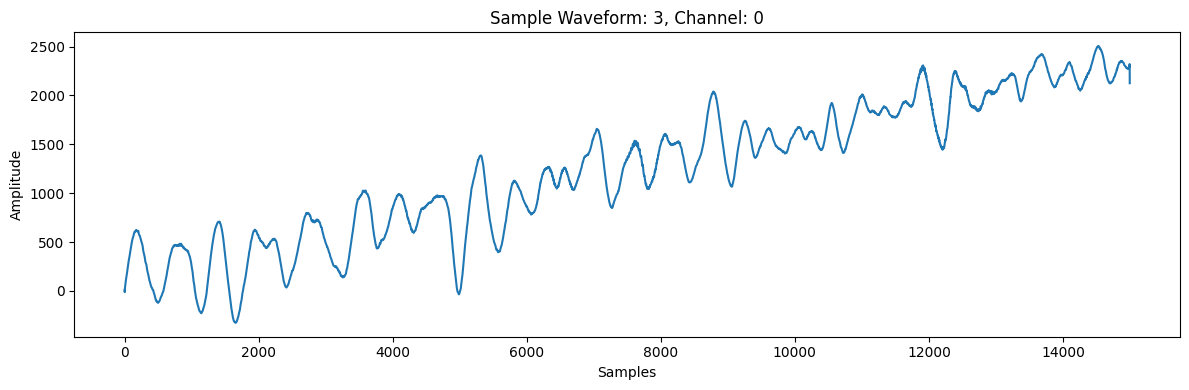

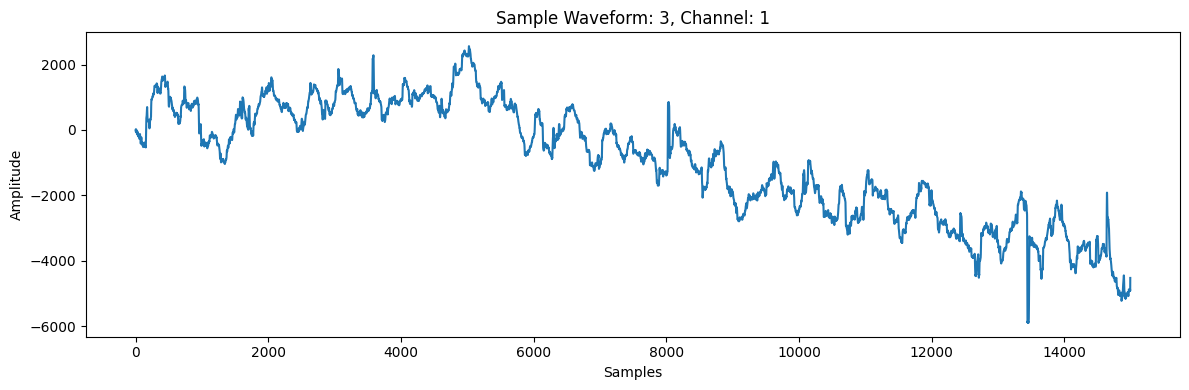

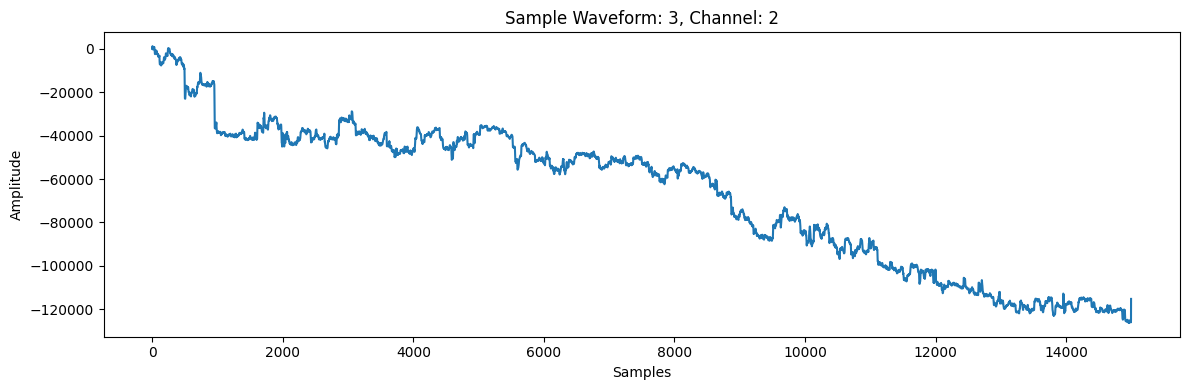

 - key 9: shape=(1, 3, 14998), min=-1756.81, max=1440.18
samplewaveform shape: (3, 14998)


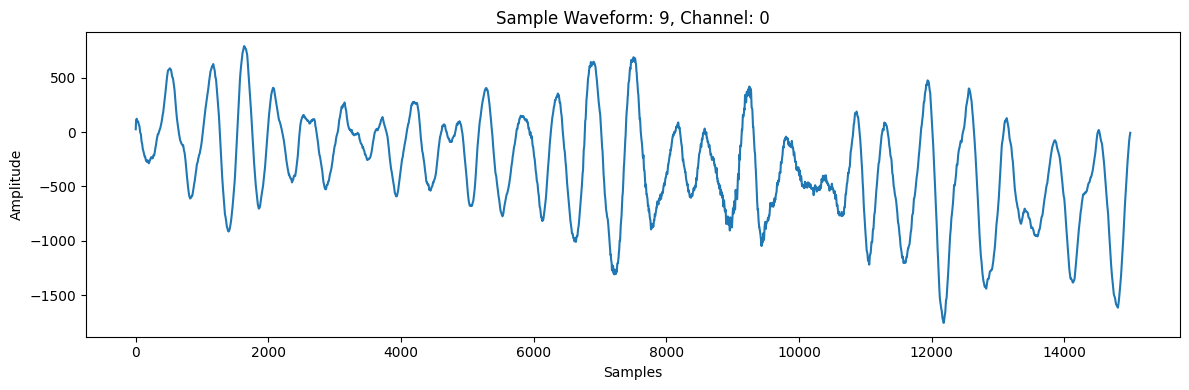

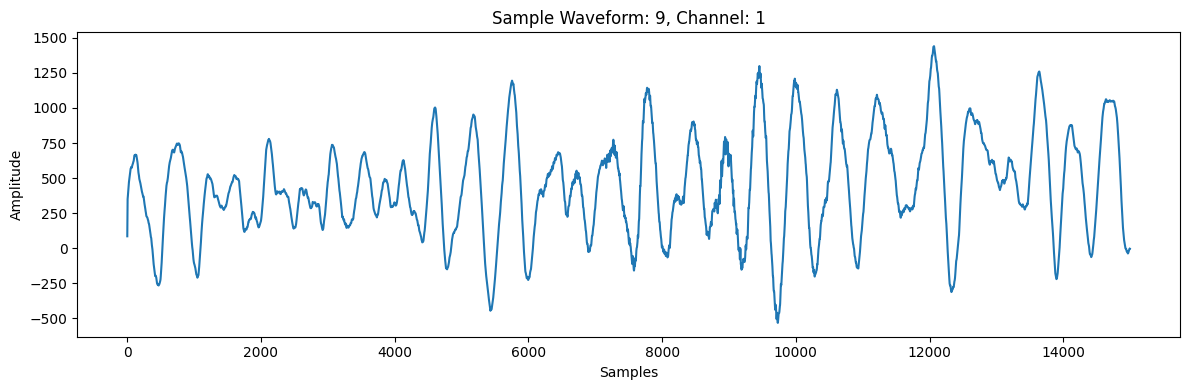

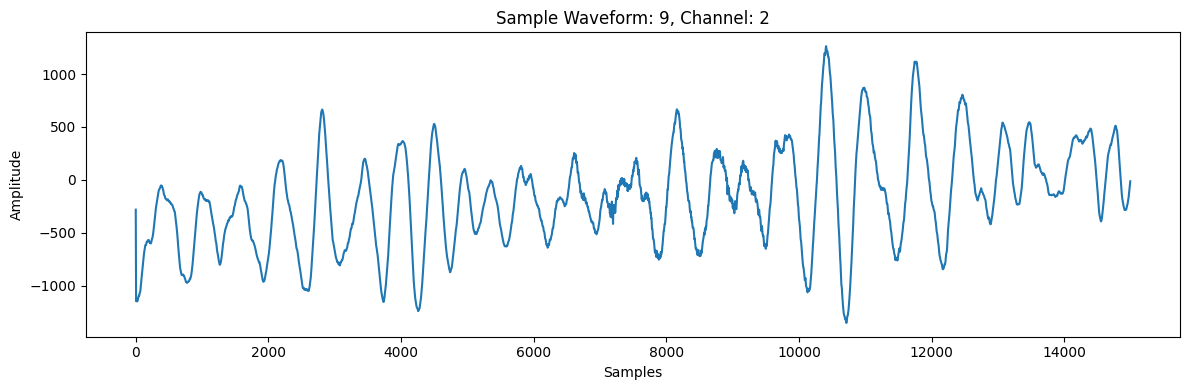

In [7]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        for i, key in enumerate(list(waveforms_group.keys())[:]):
            waveform = waveforms_group[key][:]
            print(f" - key {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
        

            print('samplewaveform shape:', waveform[0].shape)

            for i in range(len(waveform[0])):
                plt.figure(figsize=(12, 4))
                y = waveform[0,i,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {key}, Channel: {i}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
            

    
    

In [8]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

event_id           source_origin_time  source_latitude_deg  \
0  ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
1   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   

   source_longitude_deg  source_depth_km station_network_code  \
0            -122.16895          56111.0                   UW   
1            -121.77276           3820.0                   CN   

  station_channel_code station_code  station_location_code  \
0                   BH          GNW                    NaN   
1                   BH          HNB                    NaN   

   station_latitude_deg  station_longitude_deg  station_elevation_m  \
0              47.56413             -122.82498                220.0   
1              49.27450             -122.57920                183.0   

      trace_name     trace_name  trace_sampling_rate_hz  \
0  3$0,:3,:14998  3$0,:3,:14998                     100   
1  9$0,:3,:14998  9$0,:3,:14998                     100   

              trace_start_time  trace_S_arrival_sample  \
0  2010-01-01T00:14:27.262282Z                    7473   
1  2010-01-01T00:15:59.375360Z                    8764   

   trace_P_arrival_sample trace_S_onset trace_P_onset  
0                     NaN     impulsive           NaN  
1                  7134.0     impulsive     impulsive

### Verify the test datasets for EH

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '10', '2', '3', '4', '6', '7', '8', '9']>
 - 0: shape=(1, 1, 14998), min=-16.72, max=131.99
 - 10: shape=(1, 1, 14998), min=-2.47, max=305.67
 - 2: shape=(3, 1, 14998), min=-54.97, max=142.75
 - 3: shape=(1, 1, 14998), min=-347.04, max=231.93
 - 4: shape=(3, 1, 14998), min=-40.85, max=241.24
 - 6: shape=(2, 1, 14998), min=-150.89, max=151.86
 - 7: shape=(1, 1, 14998), min=-2607.16, max=861.45
 - 8: shape=(2, 1, 14998), min=-428.85, max=460.79
 - 9: shape=(4, 1, 14998), min=-494.07, max=388.02
 - key 0: shape=(1, 1, 14998), min=-16.72, max=131.99
samplewaveform shape: (1, 14998)


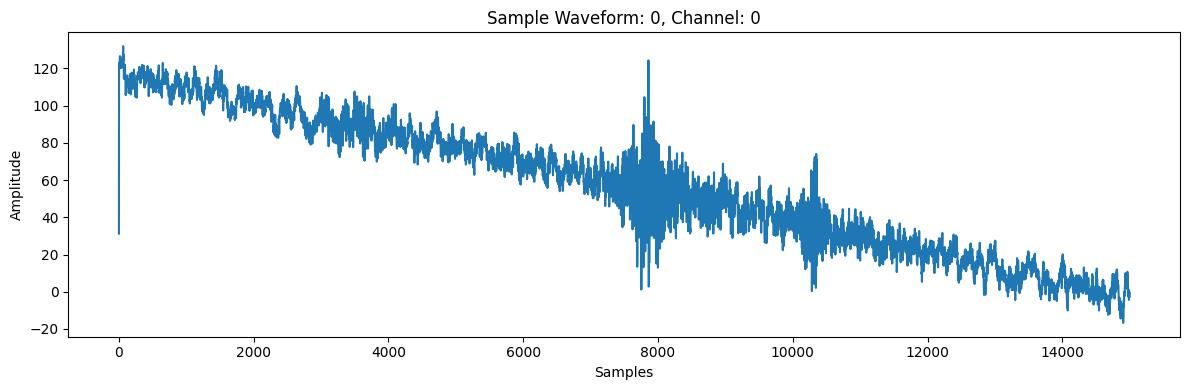

 - key 10: shape=(1, 1, 14998), min=-2.47, max=305.67
samplewaveform shape: (1, 14998)


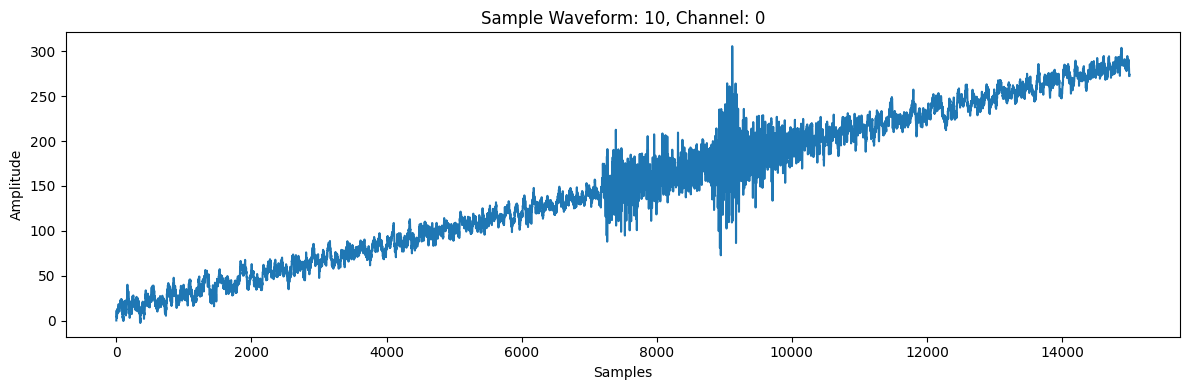

 - key 2: shape=(3, 1, 14998), min=-54.97, max=142.75
samplewaveform shape: (1, 14998)


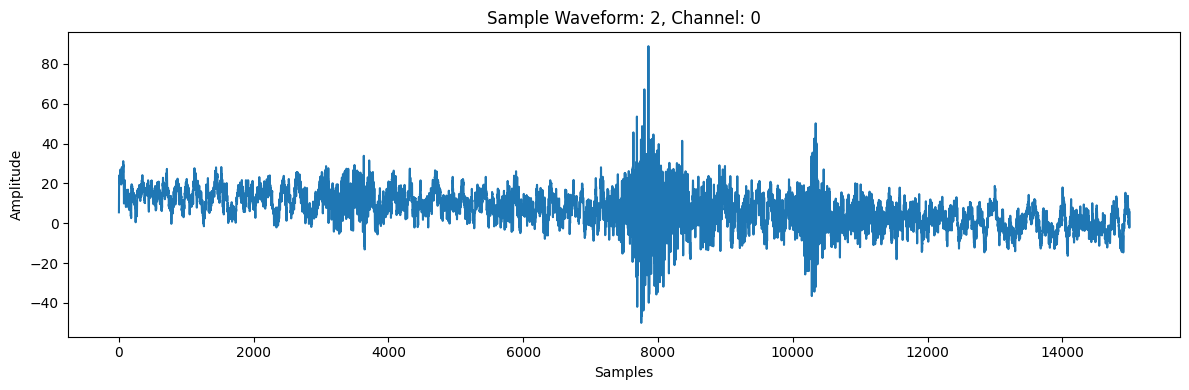

 - key 3: shape=(1, 1, 14998), min=-347.04, max=231.93
samplewaveform shape: (1, 14998)


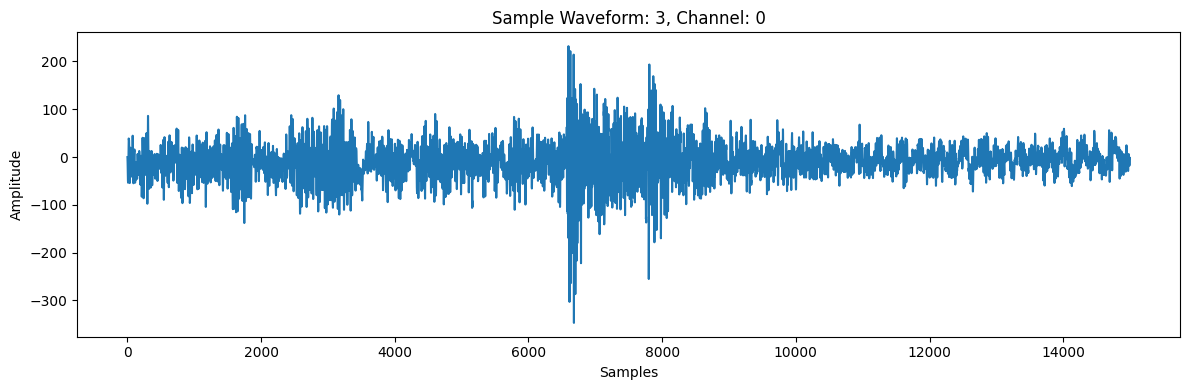

 - key 4: shape=(3, 1, 14998), min=-40.85, max=241.24
samplewaveform shape: (1, 14998)


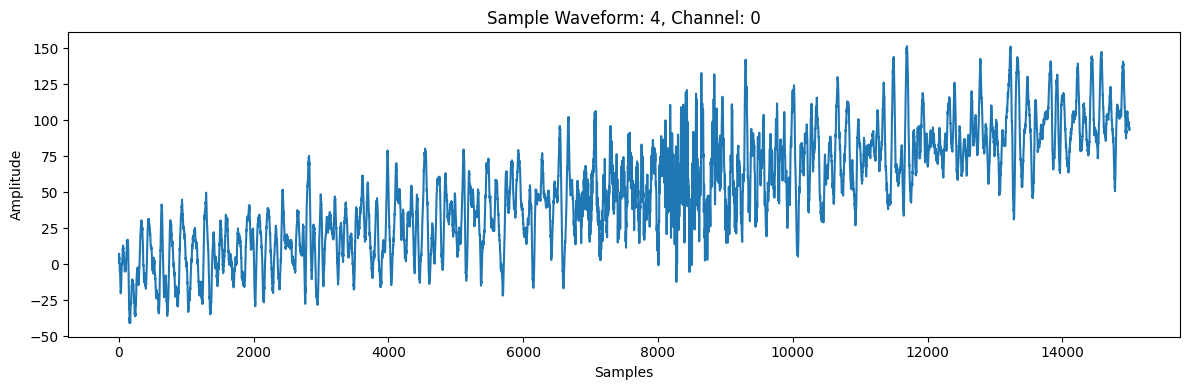

 - key 6: shape=(2, 1, 14998), min=-150.89, max=151.86
samplewaveform shape: (1, 14998)


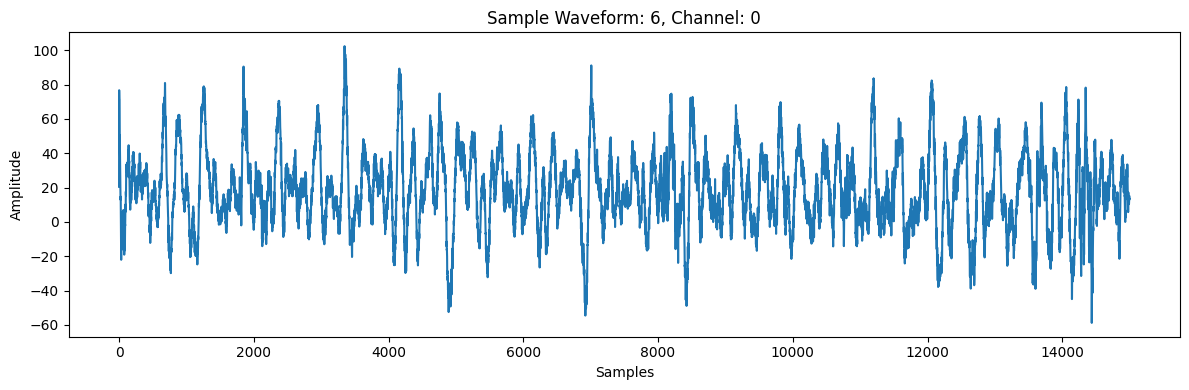

 - key 7: shape=(1, 1, 14998), min=-2607.16, max=861.45
samplewaveform shape: (1, 14998)


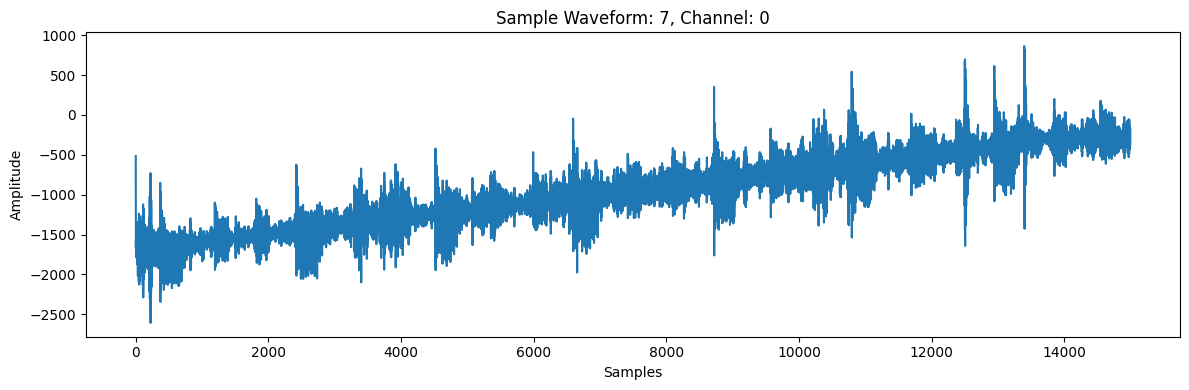

 - key 8: shape=(2, 1, 14998), min=-428.85, max=460.79
samplewaveform shape: (1, 14998)


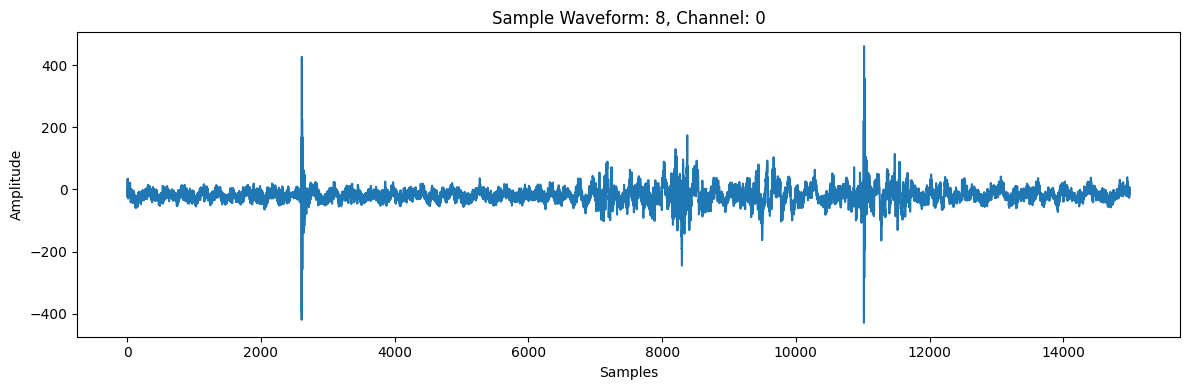

 - key 9: shape=(4, 1, 14998), min=-494.07, max=388.02
samplewaveform shape: (1, 14998)


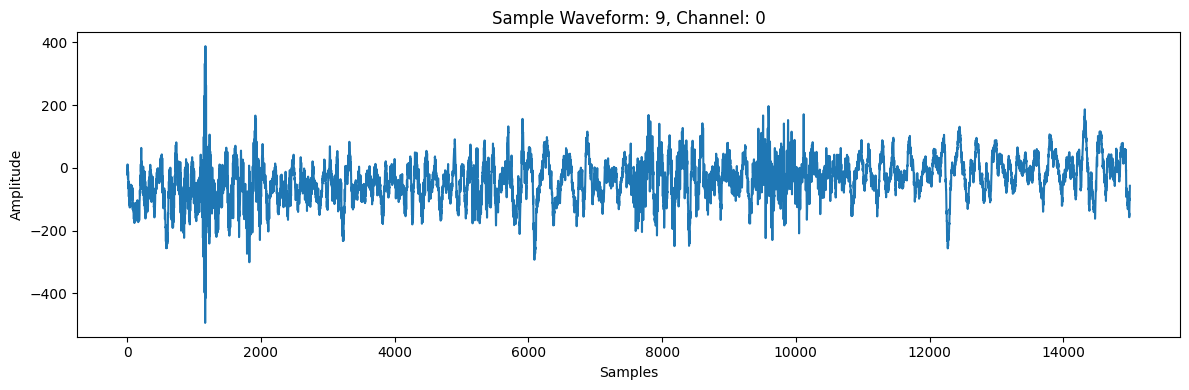

In [10]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        for i, key in enumerate(list(waveforms_group.keys())[:]):
            waveform = waveforms_group[key][:]
            print(f" - key {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
        

            print('samplewaveform shape:', waveform[0].shape)

            for i in range(len(waveform[0])):
                plt.figure(figsize=(12, 4))
                y = waveform[0,i,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {key}, Channel: {i}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
            

    


In [11]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

event_id           source_origin_time  source_latitude_deg  \
0   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
1   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
2   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
3   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
4   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
5    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
6    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
7    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
8    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
9    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
10   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
11   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
12   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
13   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
14   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
15   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
16   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
17   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   

    source_longitude_deg  source_depth_km station_network_code  \
0             -122.16895          56111.0                   PB   
1             -122.16895          56111.0                   PB   
2             -122.16895          56111.0                   UW   
3             -122.16895          56111.0                   UW   
4             -122.16895          56111.0                   UW   
5             -121.77276           3820.0                   CN   
6             -121.77276           3820.0                   CN   
7             -121.77276           3820.0                   CN   
8             -121.77276           3820.0                   CN   
9             -121.77276           3820.0                   PB   
10            -121.77276           3820.0                   PB   
11            -121.77276           3820.0                   PB   
12            -121.77276           3820.0                   PB   
13            -121.77276           3820.0                   PB   
14            -121.77276           3820.0                   PB   
15            -121.77276           3820.0                   PB   
16            -121.77276           3820.0                   PB   
17            -121.77276           3820.0                   PB   

   station_channel_code station_code  station_location_code  \
0                    EH         B013                    NaN   
1                    EH         B943                    NaN   
2                    EH          BOW                    NaN   
3                    EH         PCMD                    NaN   
4                    EH          RVW                    NaN   
5                    EH          BIB                    NaN   
6                    EH         GOBB                    NaN   
7                    EH          VDB                    NaN   
8                    EH          WPB                    NaN   
9                    EH         B001                    NaN   
10                   EH         B003                    NaN   
11                   EH         B005                    NaN   
12                   EH         B007                    NaN   
13                   EH         B011                    NaN   
14                   EH         B013                    NaN   
15                   EH         B014                    NaN   
16                   EH         B018                    NaN   
17                   EH         B023                    NaN   

    station_latitude_deg  station_longitude_deg  station_elevation_m  \
0              47.813000  

## Test the script with several occasions

### Test the script with a station from NCEDC 

In [5]:
# List rows with network 'BK'
bk_rows = assoc_df[assoc_df['sta'].str.startswith('BK.')]
bk_rows

sta     pick_time     arid iphase   prob   orid phase  timeres  \
120897   BK.JCC  1.294288e+09   120897      P  0.863   8508     P    0.117   
120934   BK.JCC  1.294293e+09   120934      P  0.706   8511     P   -0.438   
120946   BK.JCC  1.294295e+09   120946      P  0.646   8512     P   -0.199   
120951   BK.JCC  1.294302e+09   120951      P  0.608   8513     P   -0.058   
120959   BK.JCC  1.294309e+09   120959      P  0.763   8514     P   -0.277   
...         ...           ...      ...    ...    ...    ...   ...      ...   
1003911  BK.JCC  1.435053e+09  1003911      S  0.733  63860     S    1.380   
1004022  BK.JCC  1.435068e+09  1004022      P  0.676  63867     P    0.613   
1004036  BK.JCC  1.435068e+09  1004036      S  0.676  63867     S   -0.344   
1004277  BK.JCC  1.435097e+09  1004277      P  0.654  63882     P    1.069   
1004292  BK.JCC  1.435097e+09  1004292      S  0.654  63882     S    0.415   

         slatitude  slongitude  ...        lon   depth         otime  nass  \
120897   40.817451 -124.029549  ... -124.56471  17.623  1.294288e+09    22   
120934   40.817451 -124.029549  ... -124.28544  14.092  1.294293e+09    14   
120946   40.817451 -124.029549  ... -124.21149  13.675  1.294295e+09     8   
120951   40.817451 -124.029549  ... -124.57689   9.402  1.294302e+09     5   
120959   40.817451 -124.029549  ... -124.28715  13.793  1.294309e+09    10   
...            ...         ...  ...        ...     ...           ...   ...   
1003911  40.817451 -124.029549  ... -124.91113  25.160  1.435053e+09     8   
1004022  40.817451 -124.029549  ... -124.99601  18.596  1.435068e+09    25   
1004036  40.817451 -124.029549  ... -124.99601  18.596  1.435068e+09    25   
1004277  40.817451 -124.029549  ... -124.42438  19.741  1.435097e+09    23   
1004292  40.817451 -124.029549  ... -124.42438  19.741  1.435097e+09    23   

         p_picks  s_picks    rms  nsphz         gap  algorithm  
120897        12       10  0.643   10.0  260.126582      genie  
120934         7        7  0.227    7.0  210.833678      genie  
120946         4        4  0.147    4.0  187.676992      genie  
120951         1        4  0.357    4.0  283.368790      genie  
120959         5        5  0.219    5.0  211.823571      genie  
...          ...      ...    ...    ...         ...        ...  
1003911        1        7  1.528    7.0   90.180756      genie  
1004022        5       20  0.933   20.0  159.106064      genie  
1004036        5       20  0.933   20.0  159.106064      genie  
1004277        9       14  1.015   14.0   73.959960      genie  
1004292        9       14  1.015   14.0   73.959960      genie  

[22312 rows x 25 columns]

In [6]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test_BK_NC.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test_BK_NC.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test_BK_NC.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test_BK_NC.csv"

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Placeholder for client instances
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = client_iris  # replace with actual waveform client if different

# Replace with your actual DataFrame
# df = pd.read_csv(...) or load your 'close_to_midnight'
df = bk_rows.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

waveform_buckets_HH_BH = {str(i): [] for i in range(11)}
waveform_buckets_EH = {str(i): [] for i in range(11)}
rows_HH_BH, rows_EH = [], []

def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        next_day = current.date + timedelta(days=1)  # Correct way to get the next day
        chunk_end = min(obspy.UTCDateTime(next_day), endtime)
        try:
            st_chunk = client.get_waveforms(
                network=network, station=station,
                location=location, channel=channel,
                starttime=current, endtime=chunk_end
            )
            stream += st_chunk
        except Exception as e:
            print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = chunk_end
    return stream


count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    print("-" * 50)
    # print("network:", network)
    # print("station:", station)
    # print("count:", count)
    # count += 1

    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")

    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time
    trace_end = trace_start + window_length

    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)

    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    try:
        sta = client_iris.get_stations(network=network, station=station, location="*", channel="*",
                                       starttime=trace_start1, endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)
        continue

    try:
        if network in ['NC', 'BK']:
            _waveform = get_waveform_across_midnight(client_ncedc, network, station, "*", "*", trace_start1, trace_end1)
        else:
            _waveform = get_waveform_across_midnight(client_waveform, network, station, "*", "?H?", trace_start1, trace_end1)

        _waveform.merge(method=1, fill_value='interpolate')
        for tr in _waveform:
            tr.data = tr.data.astype(np.float64)
        _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0.0)
        _waveform.detrend()
        _waveform.resample(sampling_rate)

    except Exception as e:
        print("Error during waveform processing:", e)
        continue
    
    # print(_waveform)
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0] * 1000
    slat = sta[0][0].latitude
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    waveform = Stream()
    has_Z = bool(_waveform.select(channel='??Z'))
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue

    if has_HH:
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    for i, tr in enumerate(waveform):
        print(f"Trace {i}: id={tr.id}, channel={tr.stats.channel}, shape={tr.data.shape}")

    station_channel_code = waveform[0].stats.channel[:-1]
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
    num_trs, num_tps = data.shape

    p_sample = int((p_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not p_arrival.empty else None
    s_sample = int((s_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not s_arrival.empty else None

    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1089945/4087568467.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
No S arrival for event ev1294288193_014992 at station JCC
Trace start: 2011-01-06T04:29:03.014992Z, Trace end: 2011-01-06T04:31:33.014992Z
Trace 0: id=BK.JCC.00.HHE, channel=HHE, shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, channel=HHN, shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, channel=HHZ, shape=(15001,)
--------------------------------------------------
No S arrival for event ev1294293162_942228 at station JCC
Trace start: 2011-01-06T05:51:52.942228Z, Trace end: 2011-01-06T05:54:22.942228Z
Trace 0: id=BK.JCC.00.HHE, channel=HHE, shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, channel=HHN, shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, channel=HHZ, shape=(15001,)
--------------------------------------------------
No S arrival for event ev1294295275_237561 at station JCC
Trace start: 2011-01-06T06:27:05.237561Z, Trace end: 2011-01-06T06:29:35.237561Z
Trace 0: id=BK.JCC.00.HHE, channel=HHE, shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, channel=HHN, shape

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(2, 3, 14998), min=-27680.32, max=31097.23
 - 1: shape=(2, 3, 14998), min=-28604.44, max=33089.27
 - 10: shape=(2, 3, 14998), min=-7406.85, max=15413.95
 - 2: shape=(2, 3, 14998), min=-3983.71, max=16869.29
 - 3: shape=(1, 3, 14998), min=-2956.93, max=14205.01
 - 4: shape=(1, 3, 14998), min=-7201.57, max=21640.84
 - 5: shape=(3, 3, 14998), min=-8110.62, max=17427.54
 - 6: shape=(1, 3, 14998), min=-2801.49, max=16962.61
 - 7: shape=(3, 3, 14998), min=-6157.52, max=18005.95
 - 8: shape=(2, 3, 14998), min=-7728.21, max=16890.57
 - 9: shape=(1, 3, 14998), min=-7043.71, max=15797.04
 - key 0: shape=(2, 3, 14998), min=-27680.32, max=31097.23
samplewaveform shape: (3, 14998)


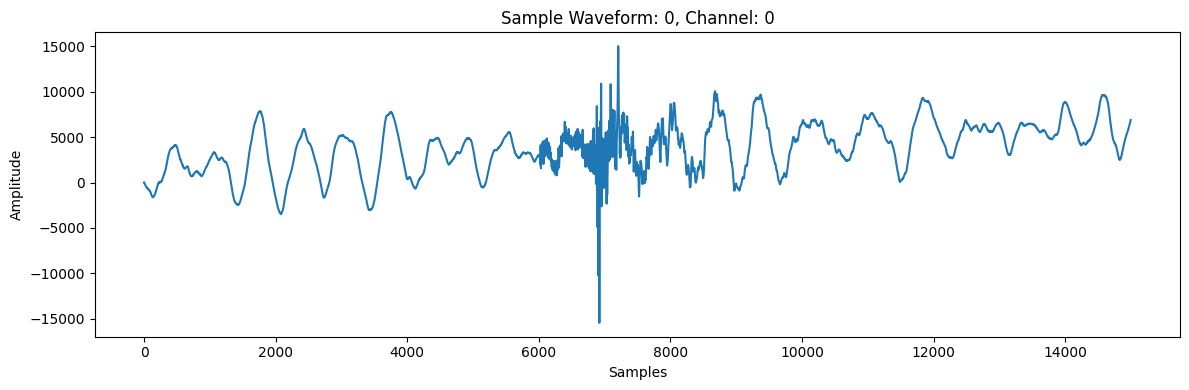

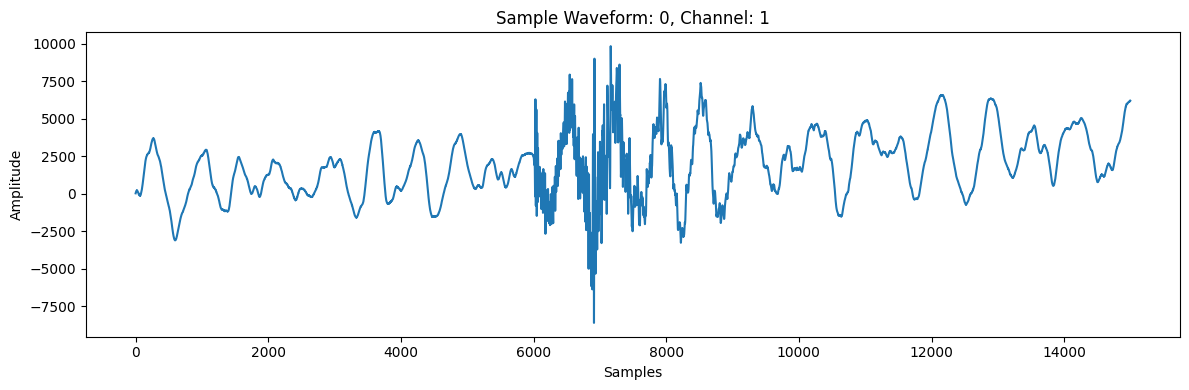

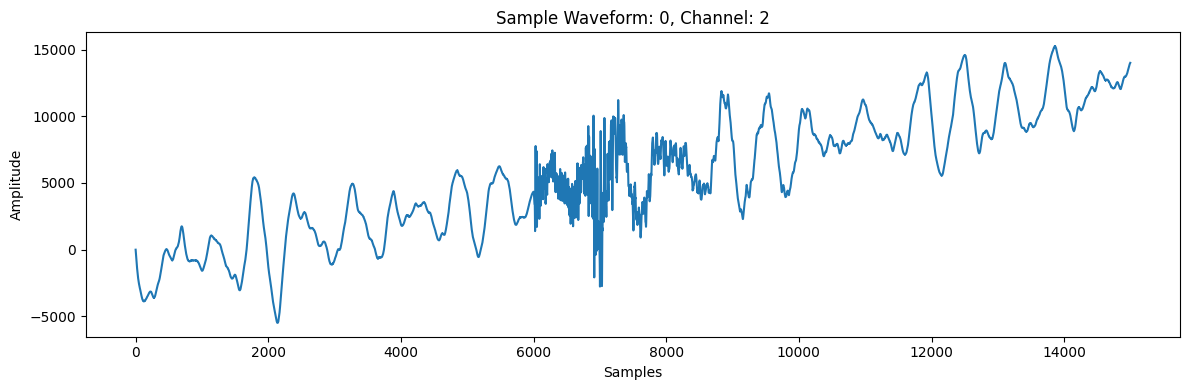

 - key 1: shape=(2, 3, 14998), min=-28604.44, max=33089.27
samplewaveform shape: (3, 14998)


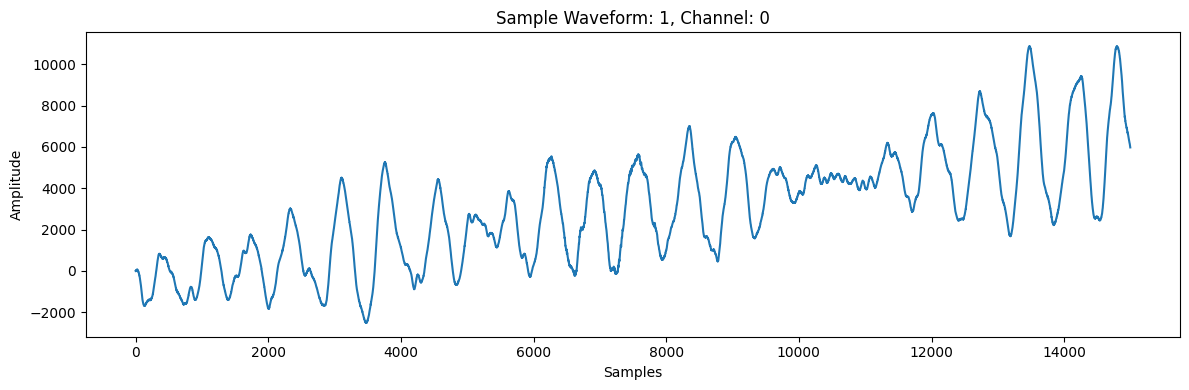

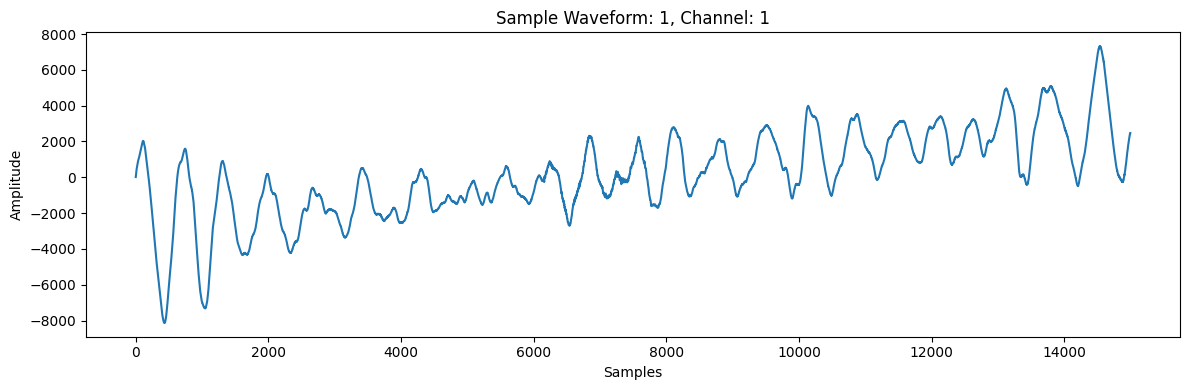

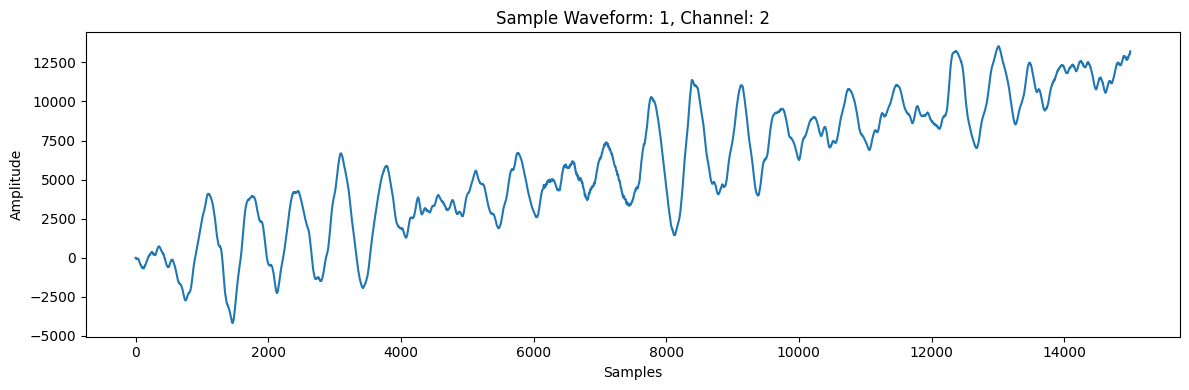

 - key 10: shape=(2, 3, 14998), min=-7406.85, max=15413.95
samplewaveform shape: (3, 14998)


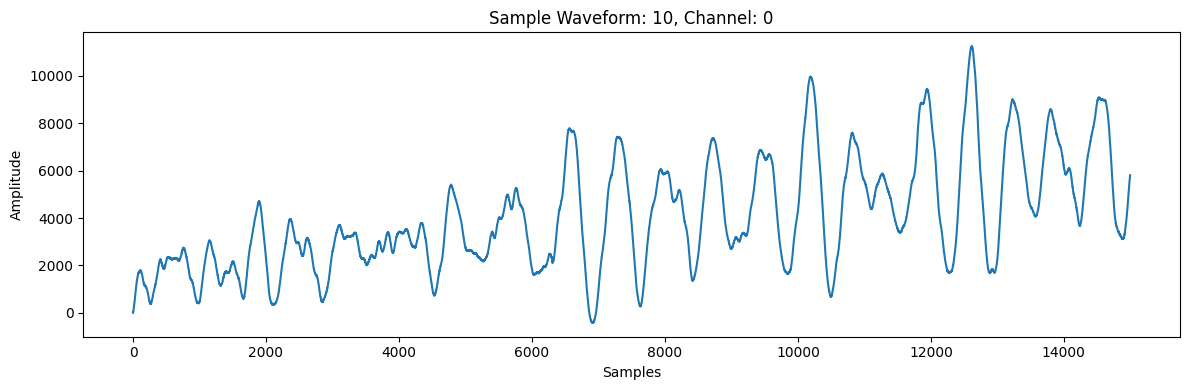

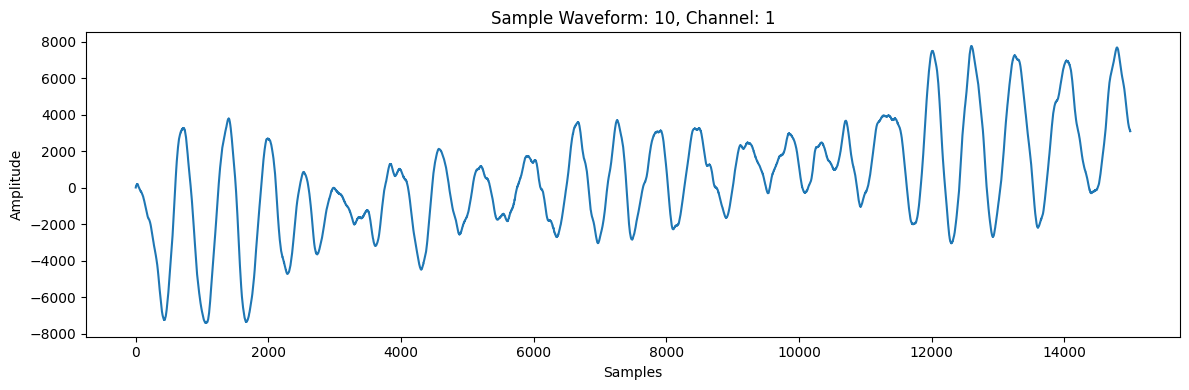

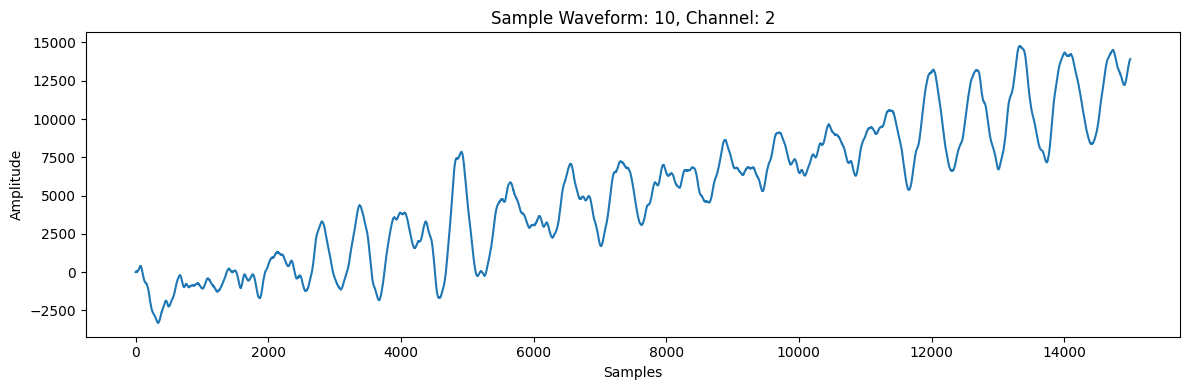

 - key 2: shape=(2, 3, 14998), min=-3983.71, max=16869.29
samplewaveform shape: (3, 14998)


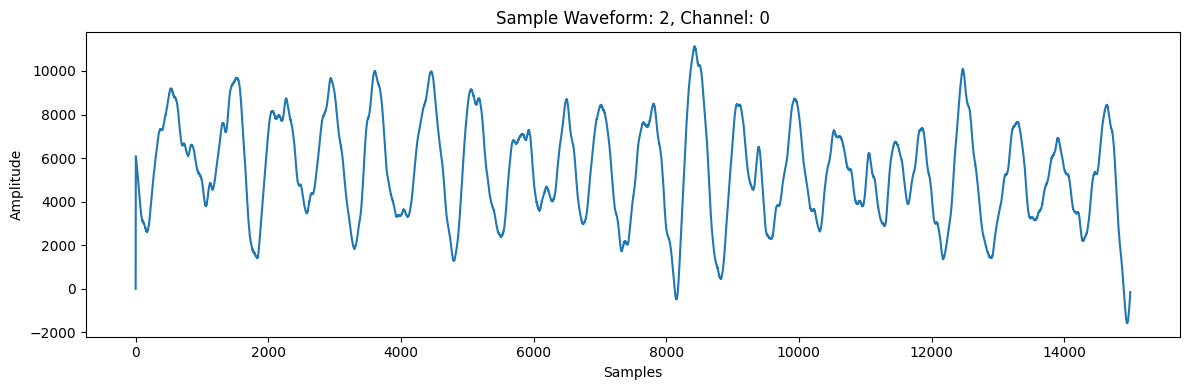

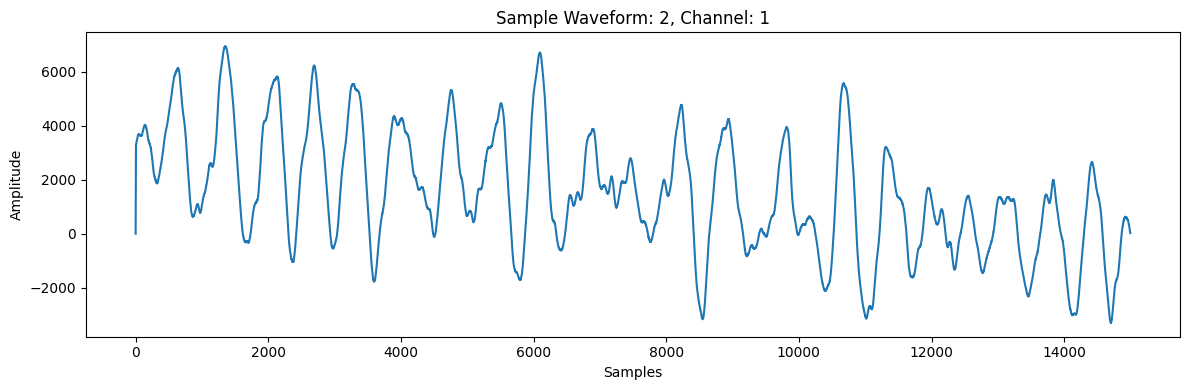

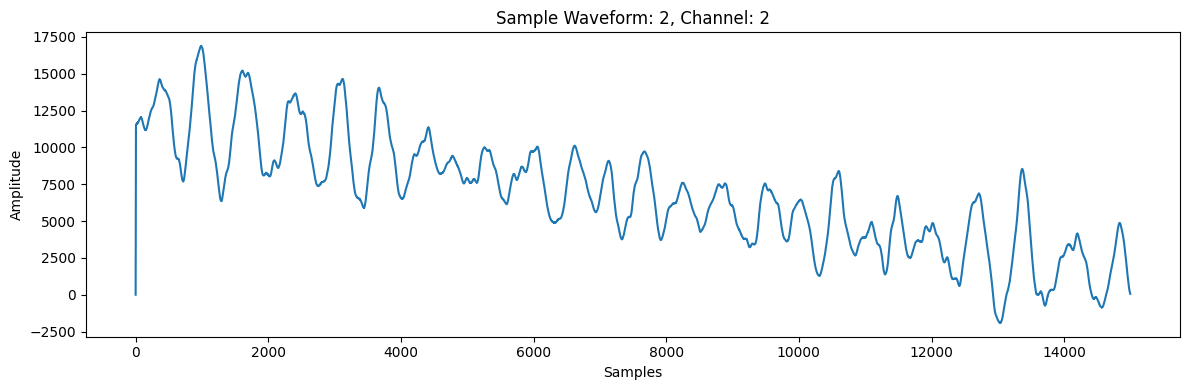

 - key 3: shape=(1, 3, 14998), min=-2956.93, max=14205.01
samplewaveform shape: (3, 14998)


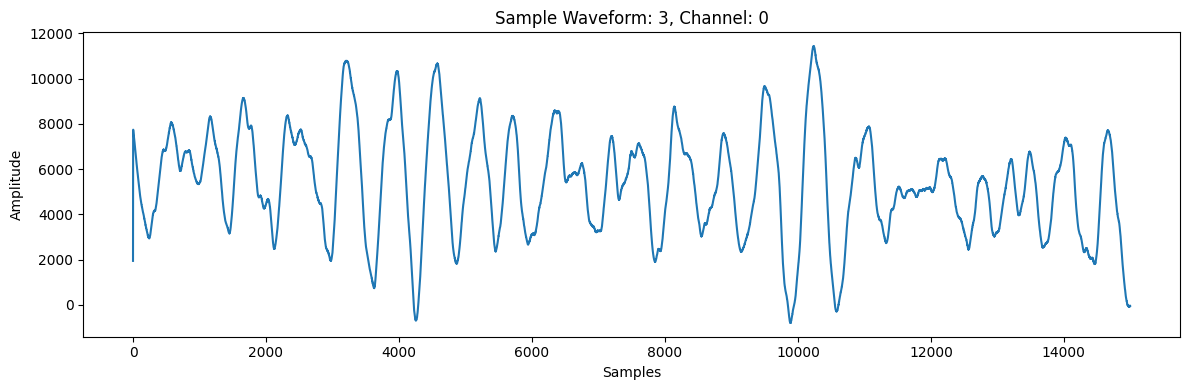

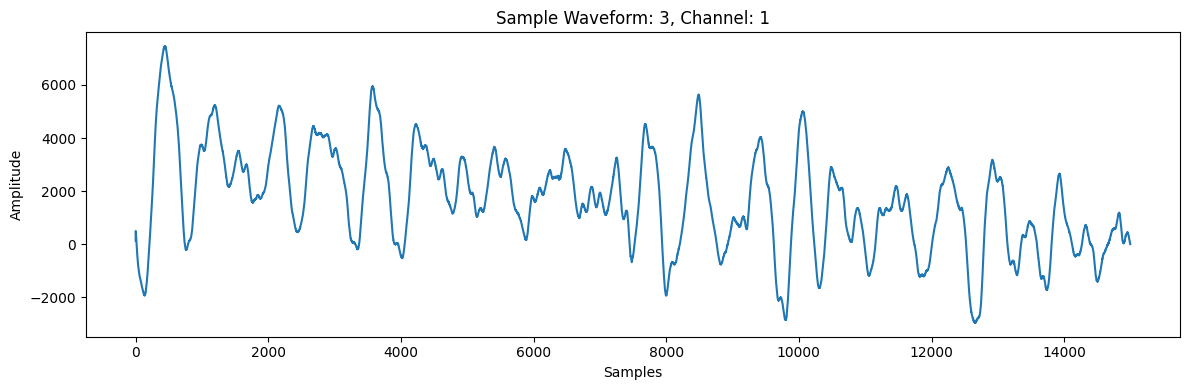

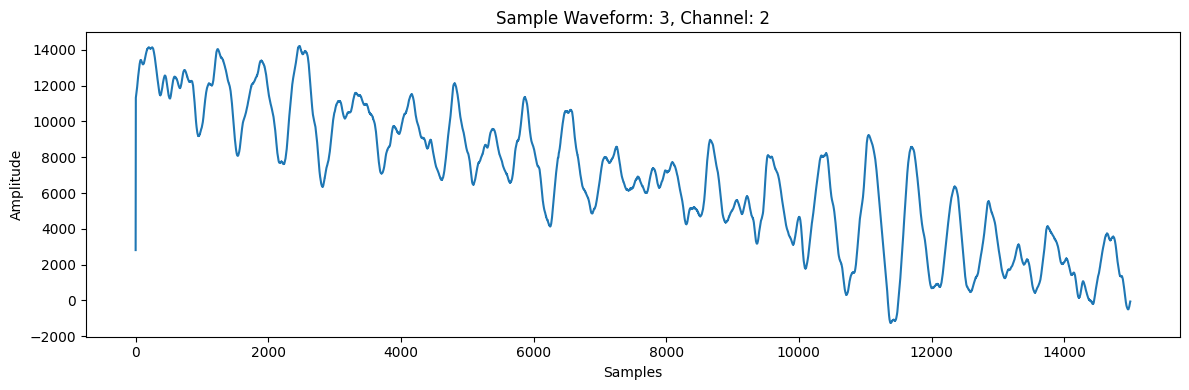

 - key 4: shape=(1, 3, 14998), min=-7201.57, max=21640.84
samplewaveform shape: (3, 14998)


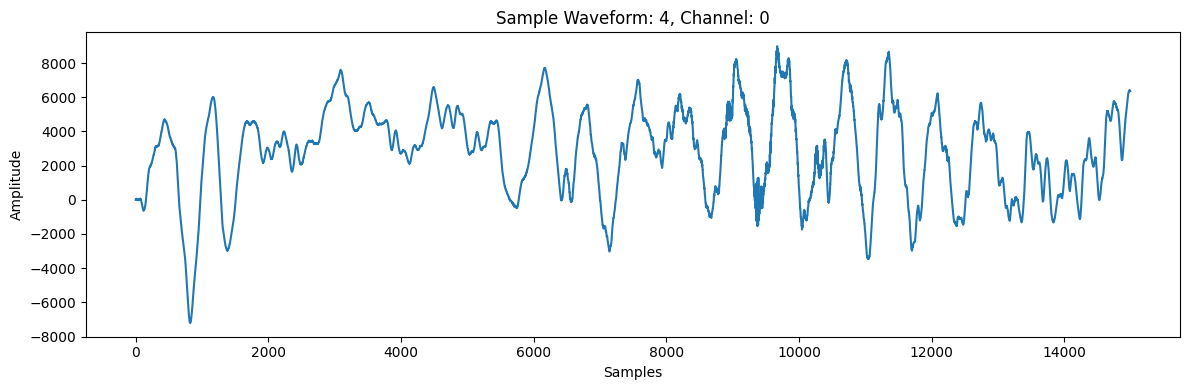

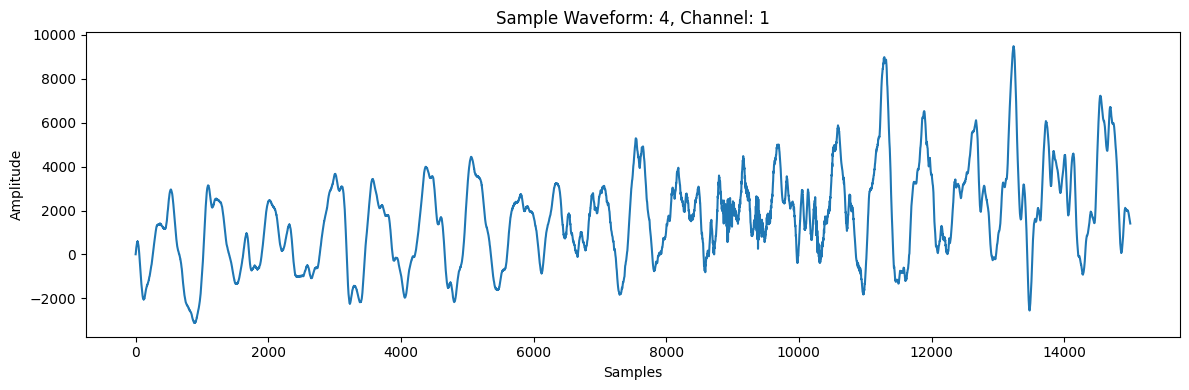

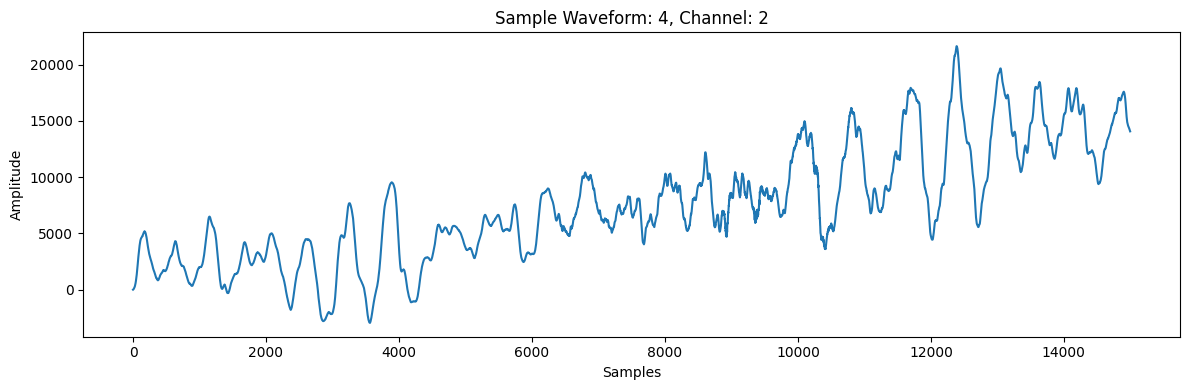

 - key 5: shape=(3, 3, 14998), min=-8110.62, max=17427.54
samplewaveform shape: (3, 14998)


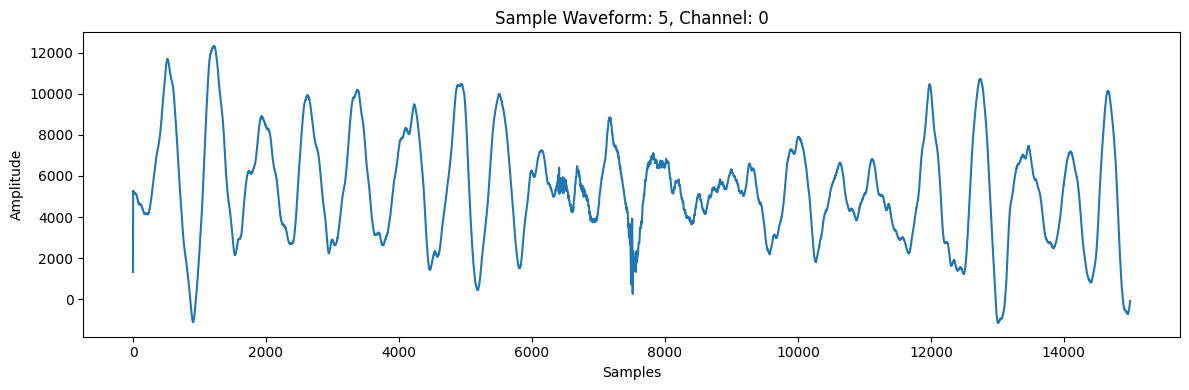

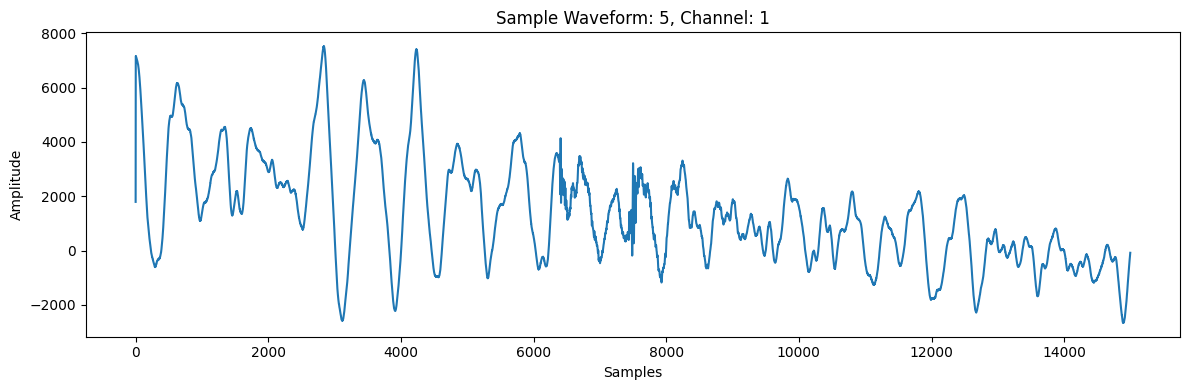

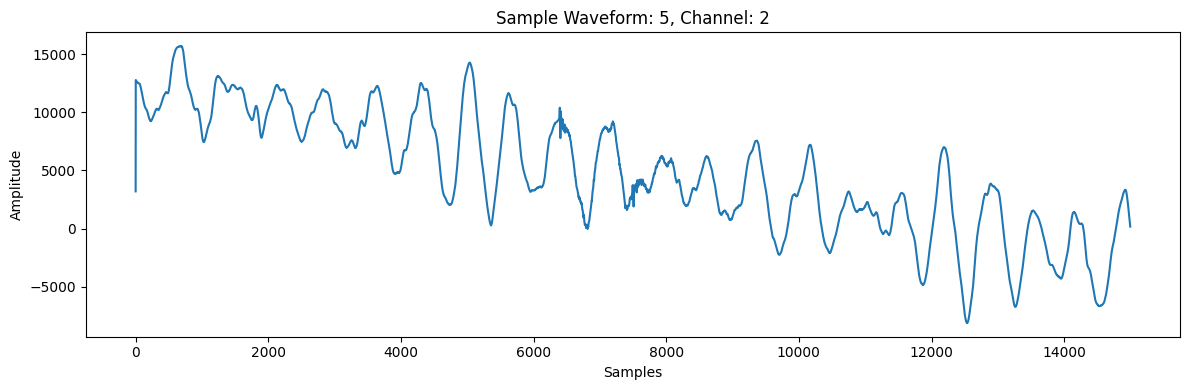

 - key 6: shape=(1, 3, 14998), min=-2801.49, max=16962.61
samplewaveform shape: (3, 14998)


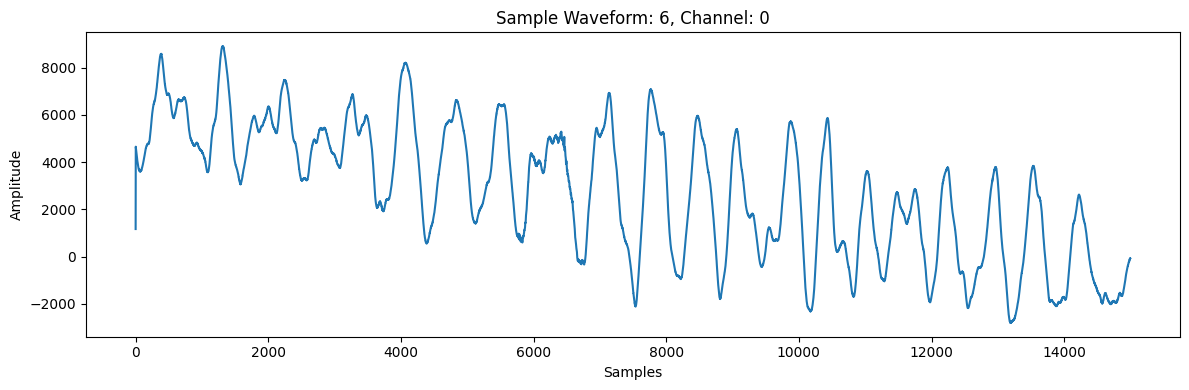

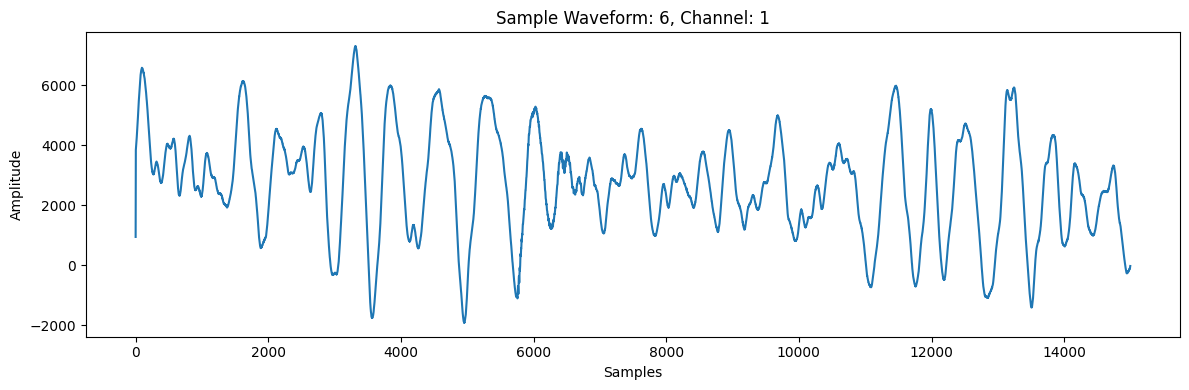

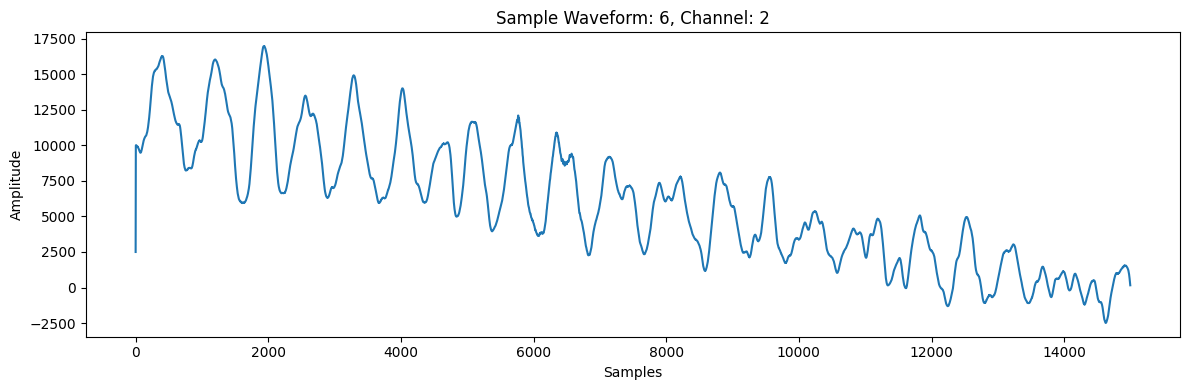

 - key 7: shape=(3, 3, 14998), min=-6157.52, max=18005.95
samplewaveform shape: (3, 14998)


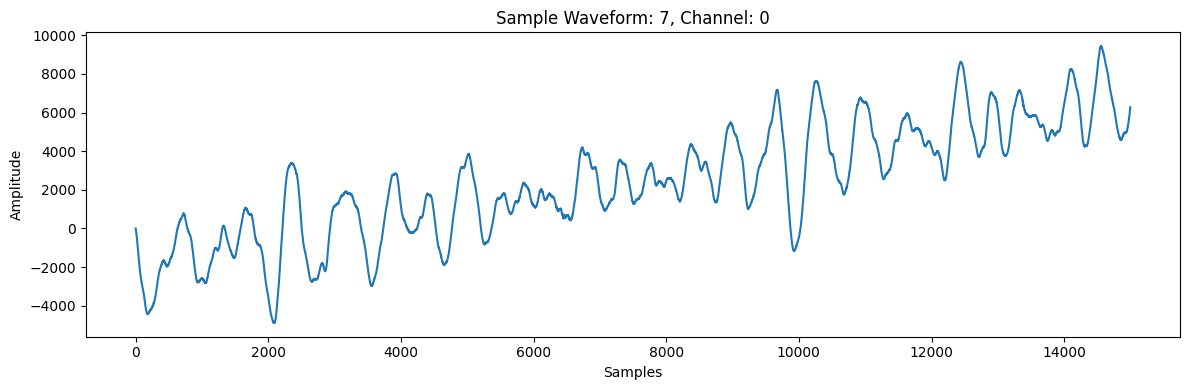

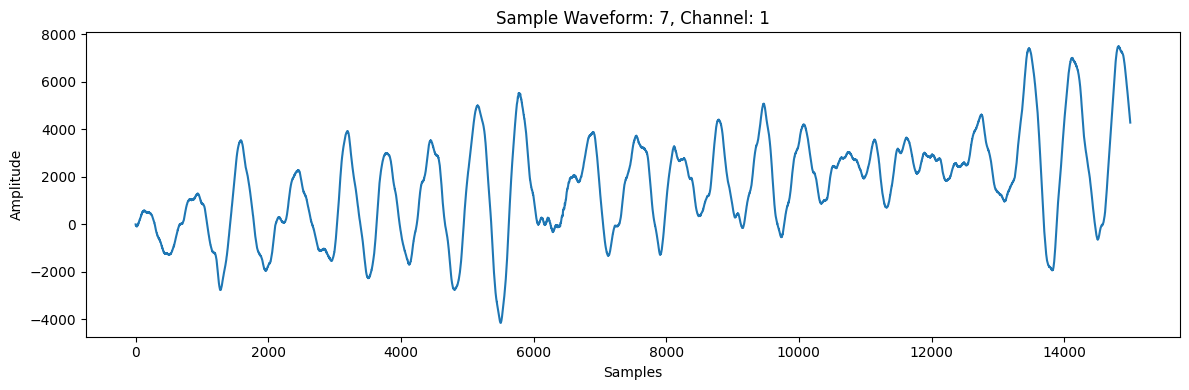

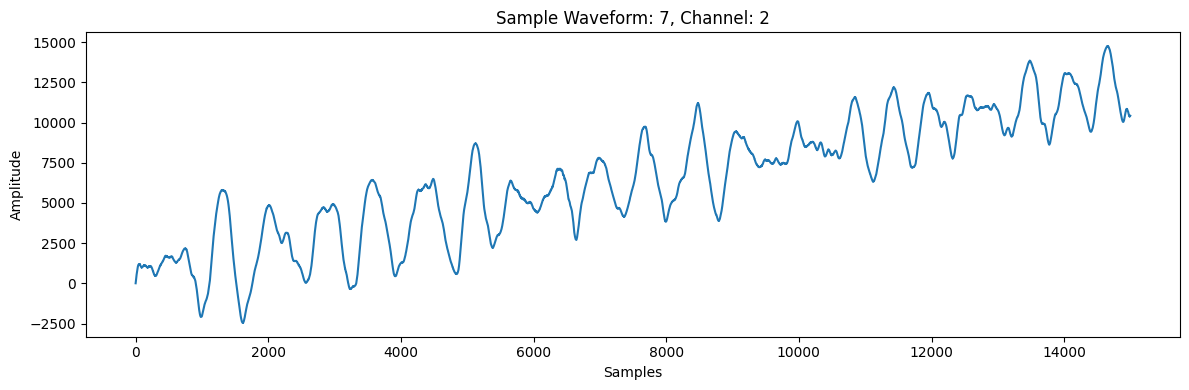

 - key 8: shape=(2, 3, 14998), min=-7728.21, max=16890.57
samplewaveform shape: (3, 14998)


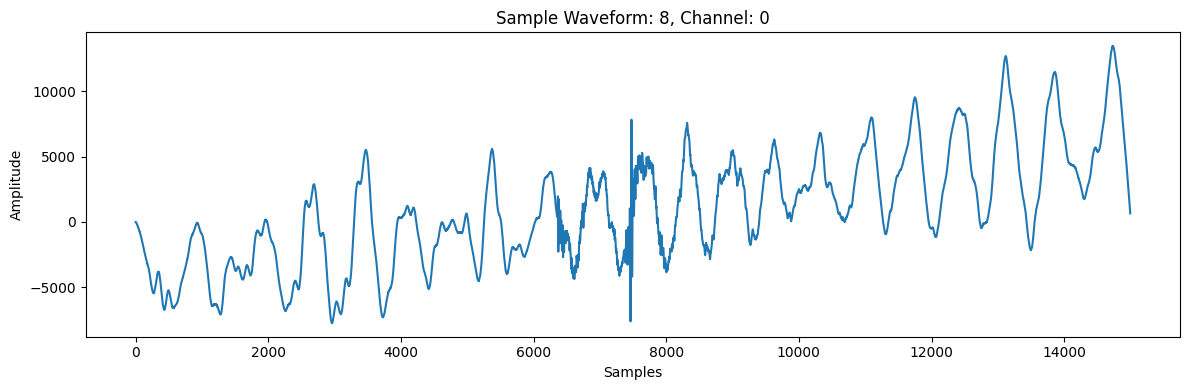

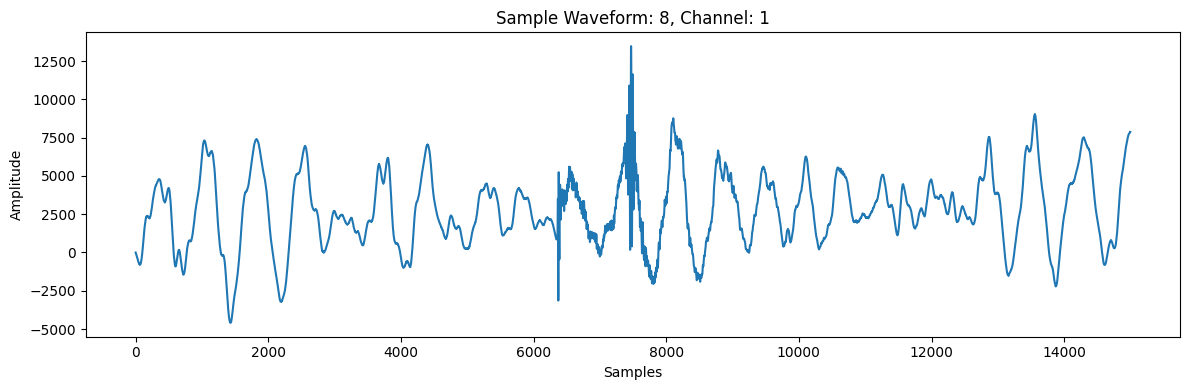

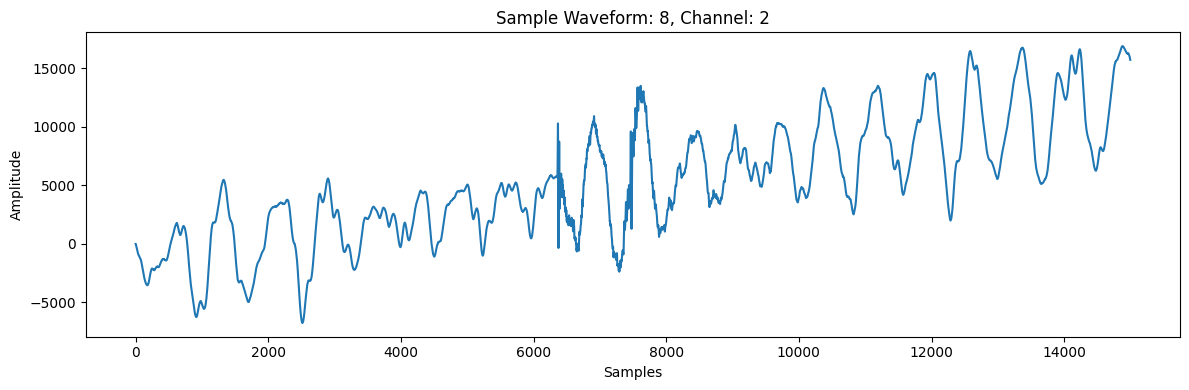

 - key 9: shape=(1, 3, 14998), min=-7043.71, max=15797.04
samplewaveform shape: (3, 14998)


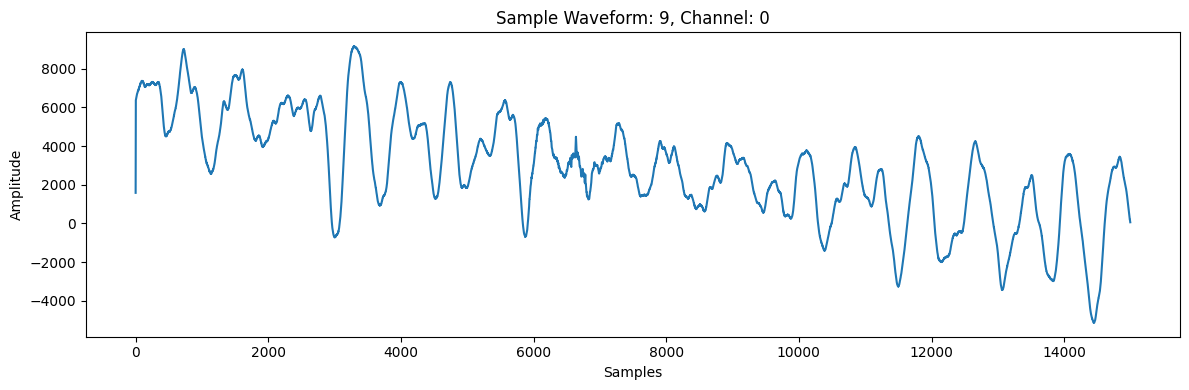

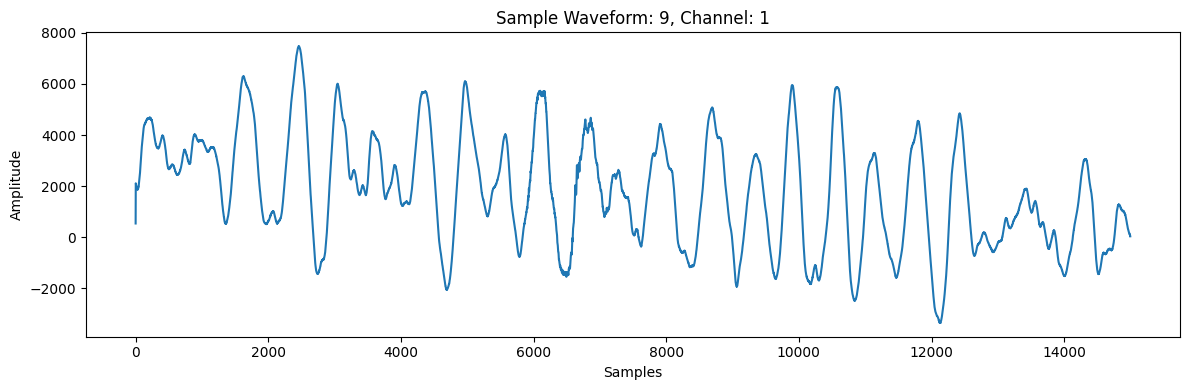

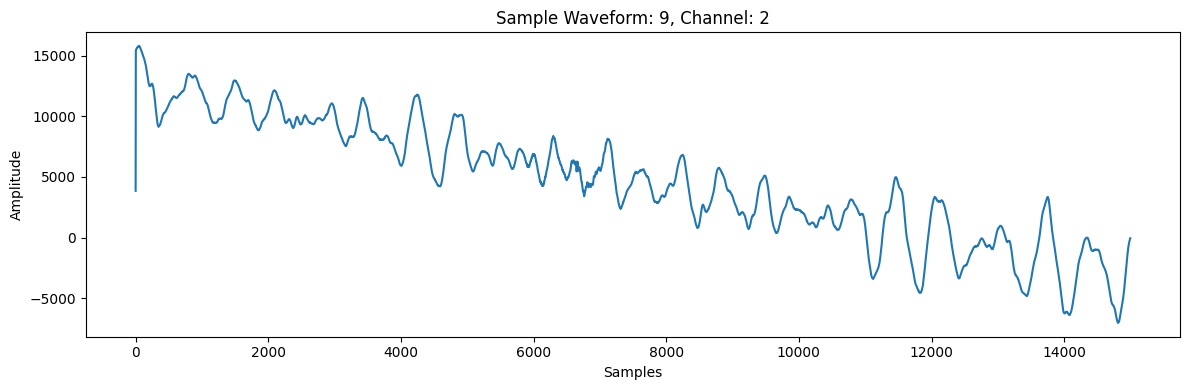

In [7]:
# Plot the waveforms from the HDF5 file
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test_BK_NC.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        for i, key in enumerate(list(waveforms_group.keys())[:]):
            waveform = waveforms_group[key][:]
            print(f" - key {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
        

            print('samplewaveform shape:', waveform[0].shape)

            for i in range(len(waveform[0])):
                plt.figure(figsize=(12, 4))
                y = waveform[0,i,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {key}, Channel: {i}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
            

    

In [8]:
# Print the metadata from the CSV file
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test_BK_NC.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

event_id           source_origin_time  source_latitude_deg  \
0   ev1294288193_014992  2011-01-06T04:29:53.014992Z             40.31143   
1   ev1294293162_942228  2011-01-06T05:52:42.942228Z             40.48588   
2   ev1294295275_237561  2011-01-06T06:27:55.237561Z             40.50885   
3    ev1294301678_28882  2011-01-06T08:14:38.288820Z             40.67203   
4   ev1294309030_960963  2011-01-06T10:17:10.960963Z             40.49097   
5   ev1294310811_630984  2011-01-06T10:46:51.630984Z             40.61033   
6   ev1294311103_522631  2011-01-06T10:51:43.522631Z             40.48661   
7   ev1294311934_002427  2011-01-06T11:05:34.002427Z             40.40363   
8   ev1294314916_618399  2011-01-06T11:55:16.618399Z             40.32492   
9   ev1294315684_360198  2011-01-06T12:08:04.360198Z             40.35093   
10  ev1294315902_719798  2011-01-06T12:11:42.719798Z             40.37106   
11  ev1294322923_232968  2011-01-06T14:08:43.232968Z             40.72298   
12  ev1294325332_760436  2011-01-06T14:48:52.760436Z             40.72445   
13    ev1294330934_4739  2011-01-06T16:22:14.473900Z             40.43246   
14  ev1294368937_064883  2011-01-07T02:55:37.064883Z             40.37839   
15  ev1294389300_552196  2011-01-07T08:35:00.552196Z             40.48040   
16  ev1294426544_987235  2011-01-07T18:55:44.987235Z             40.43246   
17  ev1294445464_282576  2011-01-08T00:11:04.282576Z             40.18094   
18  ev1294457588_779242  2011-01-08T03:33:08.779242Z             40.30467   
19  ev1294470963_308525  2011-01-08T07:16:03.308525Z             40.37651   

    source_longitude_deg  source_depth_km station_network_code  \
0             -124.56471          17623.0                   BK   
1             -124.28544          14092.0                   BK   
2             -124.21149          13675.0                   BK   
3             -124.57689           9402.0                   BK   
4             -124.28715          13793.0                   BK   
5             -124.01280          18381.0                   BK   
6             -124.28752          14079.0                   BK   
7             -123.89723          20985.0                   BK   
8             -124.88467          27552.0                   BK   
9             -124.38521          11304.0                   BK   
10            -124.91087          17453.0                   BK   
11            -124.57737          30118.0                   BK   
12            -124.56959          18457.0                   BK   
13            -125.42025          17806.0                   BK   
14            -124.89180          18483.0                   BK   
15            -124.35925          14331.0                   BK   
16            -125.27507           7489.0                   BK   
17            -123.92556          13494.0                   BK   
18            -124.40639          16636.0                   BK   
19            -124.19248          23356.0                   BK   

   station_channel_code station_code  station_location_code  \
0                    HH          JCC                    NaN   
1                    HH          JCC                    NaN   
2                    HH          JCC                    NaN   
3                    HH          JCC                    NaN   
4                    HH          JCC                    NaN   
5                    HH          JCC                    NaN   
6                    HH          JCC                    NaN   
7                    HH          JCC                    NaN   
8                    HH          JCC                    NaN   
9                    HH          JCC                    NaN   
10                   HH          JCC                    NaN   
11                   HH          JCC                    NaN   
12                   HH          JCC                    NaN   
13                   HH          JCC                    NaN   
14                   HH          JCC                    NaN   
15

### Test the script with IRIS stations

In [10]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test_iris.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test_iris.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test_iris.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test_iris.csv"

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Placeholder for client instances
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = client_iris  # replace with actual waveform client if different

# Replace with your actual DataFrame
# df = pd.read_csv(...) or load your 'close_to_midnight'
df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

waveform_buckets_HH_BH = {str(i): [] for i in range(11)}
waveform_buckets_EH = {str(i): [] for i in range(11)}
rows_HH_BH, rows_EH = [], []

def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        next_day = current.date + timedelta(days=1)  # Correct way to get the next day
        chunk_end = min(obspy.UTCDateTime(next_day), endtime)
        try:
            st_chunk = client.get_waveforms(
                network=network, station=station,
                location=location, channel=channel,
                starttime=current, endtime=chunk_end
            )
            stream += st_chunk
        except Exception as e:
            print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = chunk_end
    return stream


count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    print("-" * 50)
    # print("network:", network)
    # print("station:", station)
    # print("count:", count)
    count += 1

    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")

    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time
    trace_end = trace_start + window_length

    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)

    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    try:
        sta = client_iris.get_stations(network=network, station=station, location="*", channel="*",
                                       starttime=trace_start1, endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)
        continue

    try:
        if network in ['NC', 'BK']:
            _waveform = get_waveform_across_midnight(client_ncedc, network, station, "*", "*", trace_start1, trace_end1)
        else:
            _waveform = get_waveform_across_midnight(client_waveform, network, station, "*", "?H?", trace_start1, trace_end1)

        _waveform.merge(method=1, fill_value='interpolate')
        for tr in _waveform:
            tr.data = tr.data.astype(np.float64)
        _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0.0)
        _waveform.detrend()
        _waveform.resample(sampling_rate)

    except Exception as e:
        print("Error during waveform processing:", e)
        continue
    
    # print(_waveform)
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0] * 1000
    slat = sta[0][0].latitude
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    waveform = Stream()
    has_Z = bool(_waveform.select(channel='??Z'))
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue

    if has_HH:
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    for i, tr in enumerate(waveform):
        print(f"Trace {i}: id={tr.id}, channel={tr.stats.channel}, shape={tr.data.shape}")

    station_channel_code = waveform[0].stats.channel[:-1]
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
    num_trs, num_tps = data.shape

    p_sample = int((p_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not p_arrival.empty else None
    s_sample = int((s_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not s_arrival.empty else None

    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1089945/54120613.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Trace 0: id=PB.B013..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 8
--------------------------------------------------
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Trace 0: id=PB.B943..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 9
--------------------------------------------------
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Trace 0: id=UW.BOW..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 0
--------------------------------------------------
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Trace 0: id=UW.GNW..BHE, channel=BHE, shape=(15002,)
Trace 1: id=UW.GNW..BHN, channel=BHN, shape=(15002,)
Trace 2: id=UW.GNW..BHZ, channel=BHZ, shape=(15002,)
--------------------------------------------------
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-0

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '3', '4', '5', '6', '8', '9']>
 - 0: shape=(2, 1, 14998), min=-58.78, max=142.75
 - 1: shape=(3, 1, 14998), min=-347.04, max=231.93
 - 10: shape=(4, 1, 14998), min=-2607.16, max=861.45
 - 3: shape=(1, 1, 14998), min=-2.47, max=305.67
 - 4: shape=(1, 1, 14998), min=-494.07, max=388.02
 - 5: shape=(1, 1, 14998), min=-30.47, max=241.24
 - 6: shape=(3, 1, 14998), min=-428.85, max=460.79
 - 8: shape=(2, 1, 14998), min=-150.89, max=151.86
 - 9: shape=(1, 1, 14998), min=-16.72, max=131.99
 - key 0: shape=(2, 1, 14998), min=-58.78, max=142.75
samplewaveform shape: (1, 14998)


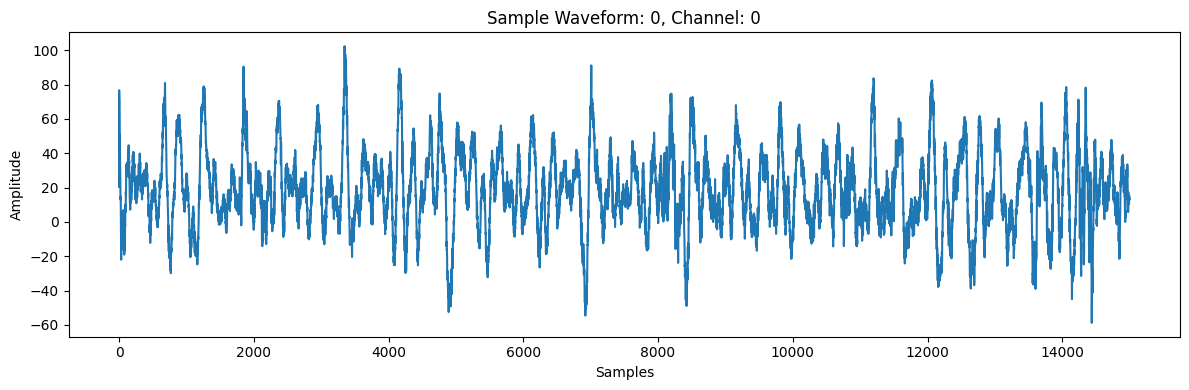

 - key 1: shape=(3, 1, 14998), min=-347.04, max=231.93
samplewaveform shape: (1, 14998)


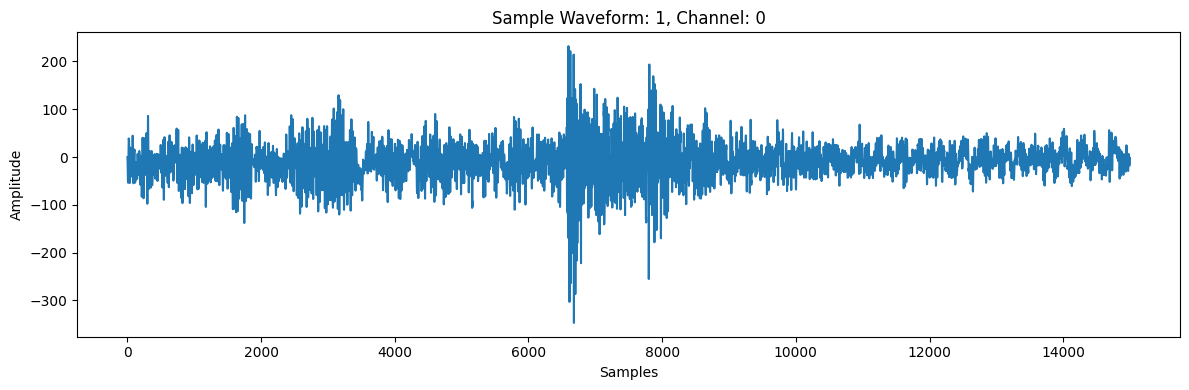

 - key 10: shape=(4, 1, 14998), min=-2607.16, max=861.45
samplewaveform shape: (1, 14998)


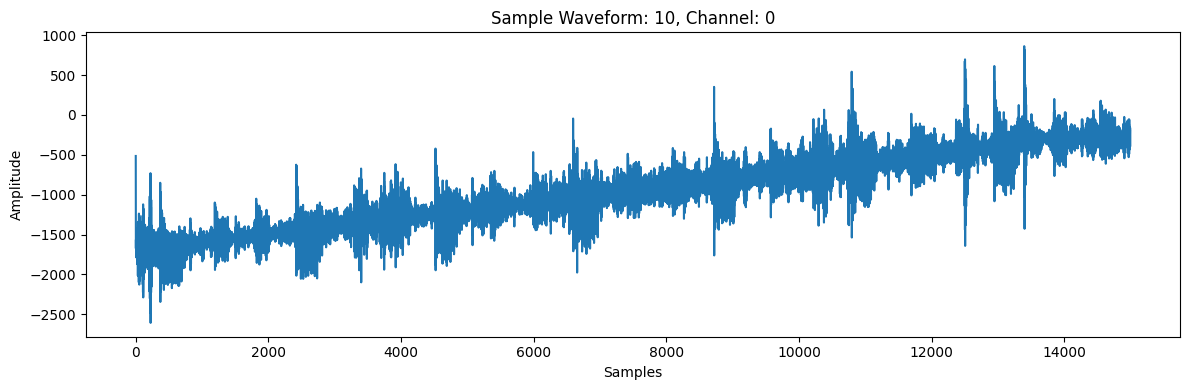

 - key 3: shape=(1, 1, 14998), min=-2.47, max=305.67
samplewaveform shape: (1, 14998)


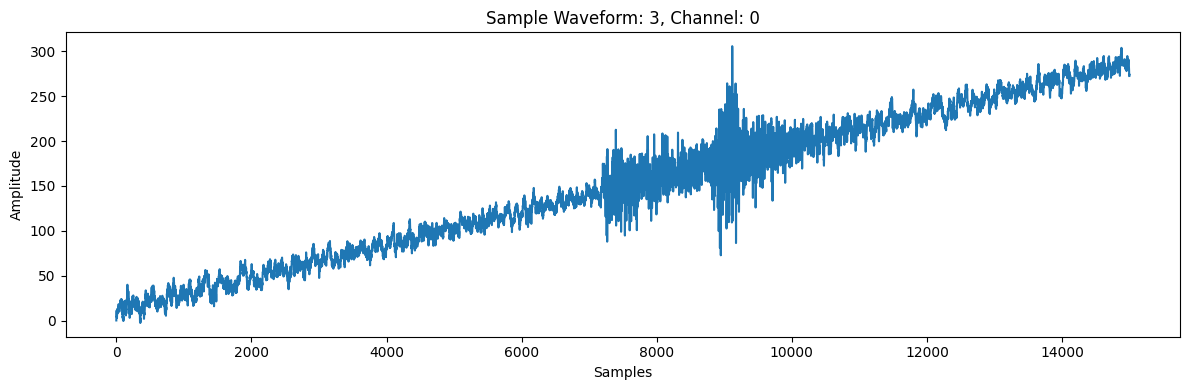

 - key 4: shape=(1, 1, 14998), min=-494.07, max=388.02
samplewaveform shape: (1, 14998)


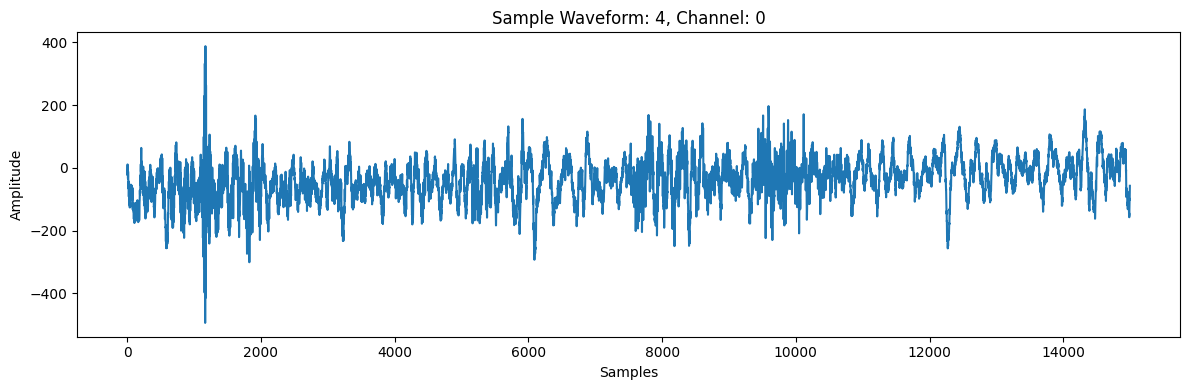

 - key 5: shape=(1, 1, 14998), min=-30.47, max=241.24
samplewaveform shape: (1, 14998)


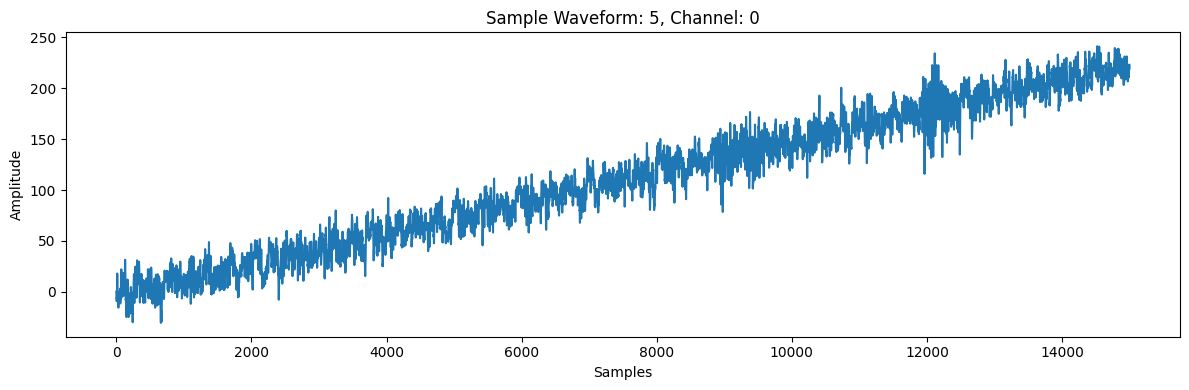

 - key 6: shape=(3, 1, 14998), min=-428.85, max=460.79
samplewaveform shape: (1, 14998)


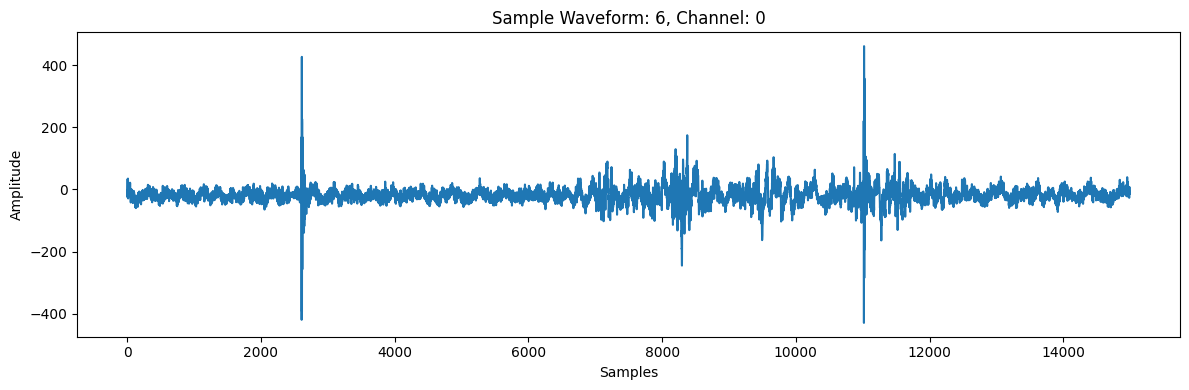

 - key 8: shape=(2, 1, 14998), min=-150.89, max=151.86
samplewaveform shape: (1, 14998)


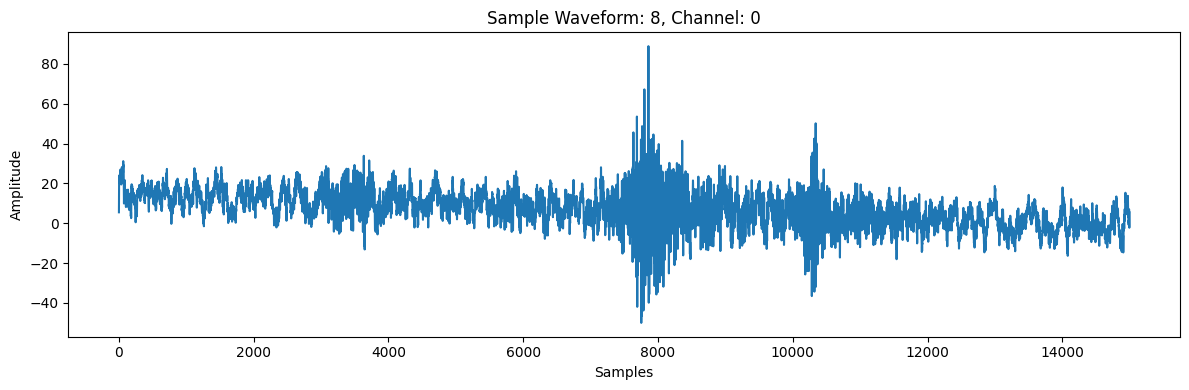

 - key 9: shape=(1, 1, 14998), min=-16.72, max=131.99
samplewaveform shape: (1, 14998)


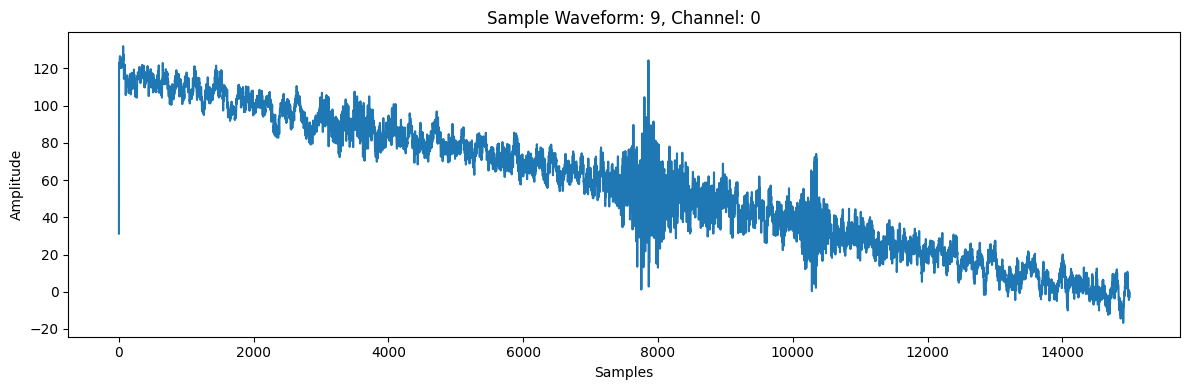

In [12]:
# Plot the waveforms from the HDF5 file
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test_iris.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        for i, key in enumerate(list(waveforms_group.keys())[:]):
            waveform = waveforms_group[key][:]
            print(f" - key {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
        

            print('samplewaveform shape:', waveform[0].shape)

            for i in range(len(waveform[0])):
                plt.figure(figsize=(12, 4))
                y = waveform[0,i,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {key}, Channel: {i}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
            

    
    

In [ ]:
# Print the metadata from the CSV file
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test_iris.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

event_id           source_origin_time  source_latitude_deg  \
0   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
1   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
2   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
3   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
4   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
5    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
6    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
7    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
8    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
9    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
10   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
11   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
12   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
13   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
14   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
15   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
16   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
17   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
18   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
19   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   

    source_longitude_deg  source_depth_km station_network_code  \
0             -122.16895          56111.0                   PB   
1             -122.16895          56111.0                   PB   
2             -122.16895          56111.0                   UW   
3             -122.16895          56111.0                   UW   
4             -122.16895          56111.0                   UW   
5             -121.77276           3820.0                   CN   
6             -121.77276           3820.0                   CN   
7             -121.77276           3820.0                   CN   
8             -121.77276           3820.0                   CN   
9             -121.77276           3820.0                   PB   
10            -121.77276           3820.0                   PB   
11            -121.77276           3820.0                   PB   
12            -121.77276           3820.0                   PB   
13            -121.77276           3820.0                   PB   
14            -121.77276           3820.0                   PB   
15            -121.77276           3820.0                   PB   
16            -121.77276           3820.0                   PB   
17            -121.77276           3820.0                   PB   
18            -121.77276           3820.0                   PB   
19            -121.77276           3820.0                   PB   

   station_channel_code station_code  station_location_code  \
0                    EH         B013                    NaN   
1                    EH         B943                    NaN   
2                    EH          BOW                    NaN   
3                    EH         PCMD                    NaN   
4                    EH          RVW                    NaN   
5                    EH          BIB                    NaN   
6                    EH         GOBB                    NaN   
7                    EH          VDB                    NaN   
8                    EH          WPB                    NaN   
9                    EH         B001                    NaN   
10                   EH         B003                    NaN   
11                   EH         B005                    NaN   
12                   EH         B007                    NaN   
13                   EH         B011                    NaN   
14                   EH         B013                    NaN   
15

### Test the script with IRIS stations with traces across days

In [13]:
# Find rows in assoc_df where pick_time is close to 23:59 (within 1 minute)
# Convert pick_time (epoch) to datetime if not already present
if 'datetime' not in assoc_df.columns:
    assoc_df['datetime'] = pd.to_datetime(assoc_df['pick_time'], unit='s')

# Find rows where the time is close to 23:59 (within 1 minute)
mask = assoc_df['datetime'].dt.time.between(pd.to_datetime('23:58:00').time(), pd.to_datetime('23:59:59').time())
close_to_midnight = assoc_df[mask]
close_to_midnight[['sta', 'pick_time', 'datetime']]

sta     pick_time                      datetime
10497    PB.B932  1.264205e+09 2010-01-22 23:58:55.418400000
10498    PB.B046  1.264205e+09 2010-01-22 23:58:55.588399872
10499    PB.B047  1.264205e+09 2010-01-22 23:58:55.748399872
10500    PB.B045  1.264205e+09 2010-01-22 23:58:56.568399872
10501    PB.B933  1.264205e+09 2010-01-22 23:58:58.258400000
...          ...           ...                           ...
988518  7D.FS09D  1.433030e+09 2015-05-30 23:58:40.414599936
988519  7D.FS41D  1.433030e+09 2015-05-30 23:58:41.911000064
988520  7D.FS10D  1.433030e+09 2015-05-30 23:58:43.394800896
988521  7D.FS07D  1.433030e+09 2015-05-30 23:58:45.841700096
988522   7D.M16D  1.433030e+09 2015-05-30 23:58:48.950364160

[1153 rows x 3 columns]

In [14]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_close_to_midnight.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_close_to_midnight.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_close_to_midnight.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_close_to_midnight.csv"

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Placeholder for client instances
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = client_iris  # replace with actual waveform client if different

# Replace with your actual DataFrame
# df = pd.read_csv(...) or load your 'close_to_midnight'
df = close_to_midnight.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

waveform_buckets_HH_BH = {str(i): [] for i in range(11)}
waveform_buckets_EH = {str(i): [] for i in range(11)}
rows_HH_BH, rows_EH = [], []

def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        next_day = current.date + timedelta(days=1)  # Correct way to get the next day
        chunk_end = min(obspy.UTCDateTime(next_day), endtime)
        try:
            st_chunk = client.get_waveforms(
                network=network, station=station,
                location=location, channel=channel,
                starttime=current, endtime=chunk_end
            )
            stream += st_chunk
        except Exception as e:
            print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = chunk_end
    return stream


count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    print("-" * 50)
    # print("network:", network)
    # print("station:", station)
    # print("count:", count)
    count += 1

    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")

    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time
    trace_end = trace_start + window_length

    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)

    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    try:
        sta = client_iris.get_stations(network=network, station=station, location="*", channel="*",
                                       starttime=trace_start1, endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)
        continue

    try:
        if network in ['NC', 'BK']:
            _waveform = get_waveform_across_midnight(client_ncedc, network, station, "*", "*", trace_start1, trace_end1)
        else:
            _waveform = get_waveform_across_midnight(client_waveform, network, station, "*", "?H?", trace_start1, trace_end1)

        _waveform.merge(method=1, fill_value='interpolate')
        for tr in _waveform:
            tr.data = tr.data.astype(np.float64)
        _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0.0)
        _waveform.detrend()
        _waveform.resample(sampling_rate)

    except Exception as e:
        print("Error during waveform processing:", e)
        continue
    
    # print(_waveform)
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0] * 1000
    slat = sta[0][0].latitude
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    waveform = Stream()
    has_Z = bool(_waveform.select(channel='??Z'))
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue

    if has_HH:
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    for i, tr in enumerate(waveform):
        print(f"Trace {i}: id={tr.id}, channel={tr.stats.channel}, shape={tr.data.shape}")

    station_channel_code = waveform[0].stats.channel[:-1]
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
    num_trs, num_tps = data.shape

    p_sample = int((p_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not p_arrival.empty else None
    s_sample = int((s_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not s_arrival.empty else None

    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1089945/2281779095.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
No S arrival for event ev1264204730_512261 at station B033
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B033..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 8
--------------------------------------------------
No S arrival for event ev1264204730_512261 at station B035
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B035..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 2
--------------------------------------------------
No S arrival for event ev1264204730_512261 at station B036
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B036..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 7
--------------------------------------------------
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B045..EHZ, channel=EHZ, shape=(15001,)
EH bucket: 4
---------------------------

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(3, 1, 14998), min=-4593.93, max=6996.90
 - 10: shape=(2, 1, 14998), min=-298.66, max=60.49
 - 2: shape=(1, 1, 14998), min=-105.47, max=22.07
 - 3: shape=(2, 1, 14998), min=-7829.59, max=7127.54
 - 4: shape=(2, 1, 14998), min=-5648.63, max=4100.85
 - 5: shape=(1, 1, 14998), min=-3247.32, max=2868.18
 - 6: shape=(2, 1, 14998), min=-1621.31, max=1420.73
 - 7: shape=(2, 1, 14998), min=-383.28, max=406.14
 - 8: shape=(3, 1, 14998), min=-2580.34, max=2636.89
 - 9: shape=(2, 1, 14998), min=-440.67, max=240.39
 - key 0: shape=(3, 1, 14998), min=-4593.93, max=6996.90
samplewaveform shape: (1, 14998)


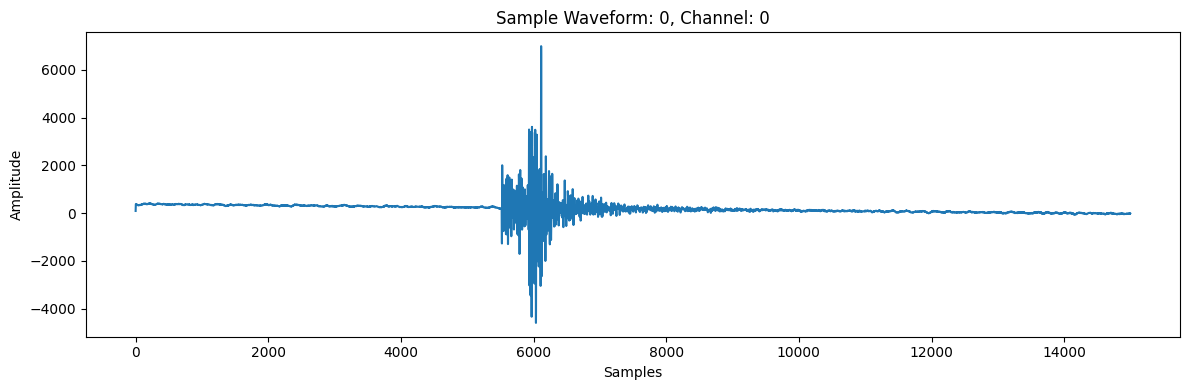

 - key 10: shape=(2, 1, 14998), min=-298.66, max=60.49
samplewaveform shape: (1, 14998)


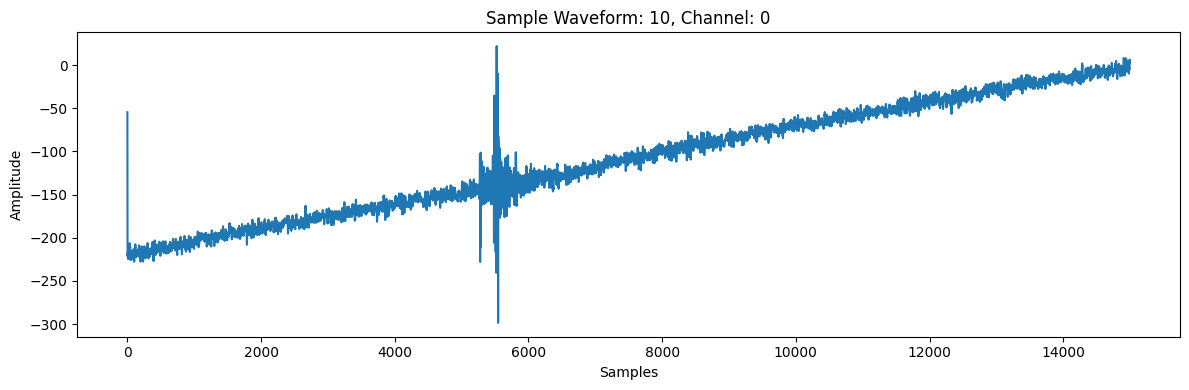

 - key 2: shape=(1, 1, 14998), min=-105.47, max=22.07
samplewaveform shape: (1, 14998)


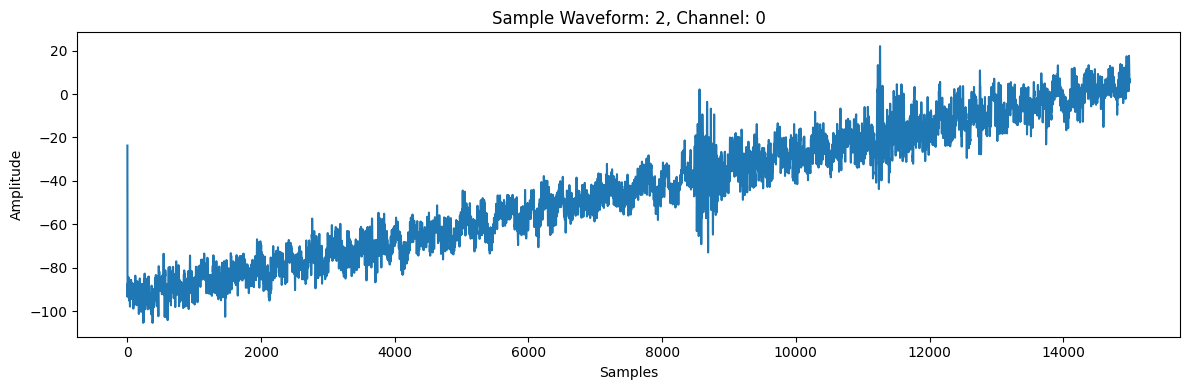

 - key 3: shape=(2, 1, 14998), min=-7829.59, max=7127.54
samplewaveform shape: (1, 14998)


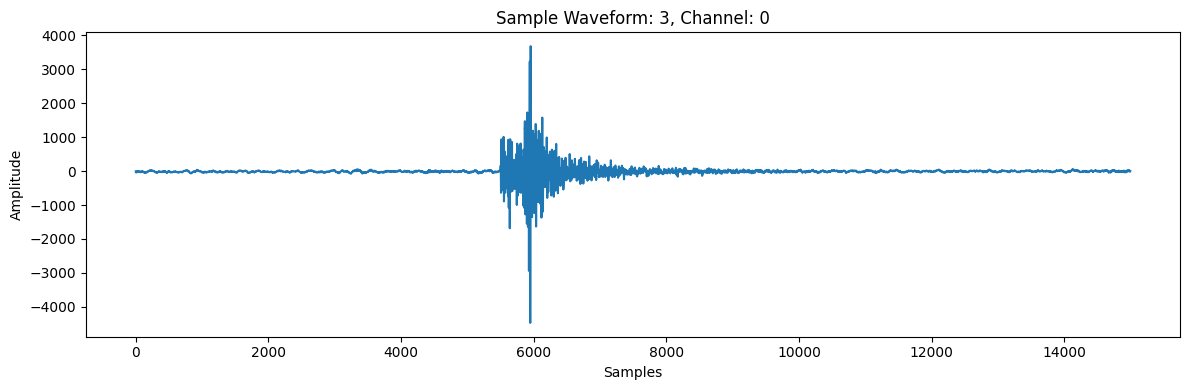

 - key 4: shape=(2, 1, 14998), min=-5648.63, max=4100.85
samplewaveform shape: (1, 14998)


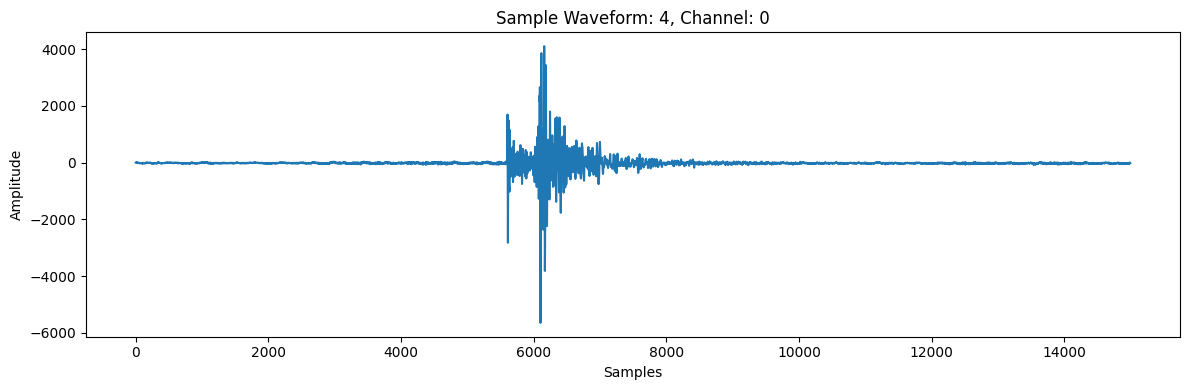

 - key 5: shape=(1, 1, 14998), min=-3247.32, max=2868.18
samplewaveform shape: (1, 14998)


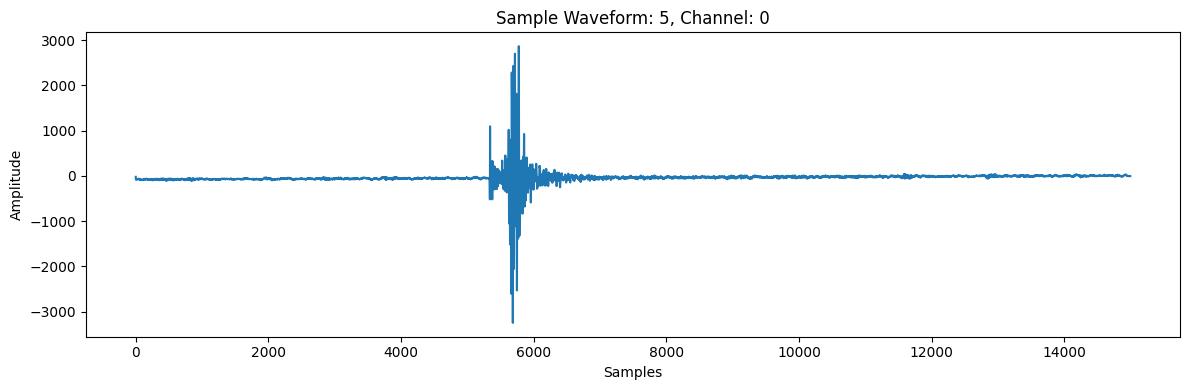

 - key 6: shape=(2, 1, 14998), min=-1621.31, max=1420.73
samplewaveform shape: (1, 14998)


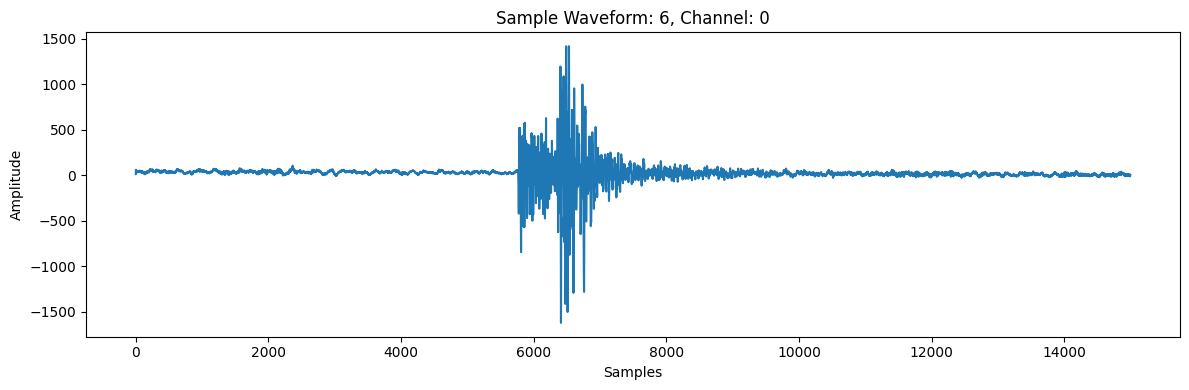

 - key 7: shape=(2, 1, 14998), min=-383.28, max=406.14
samplewaveform shape: (1, 14998)


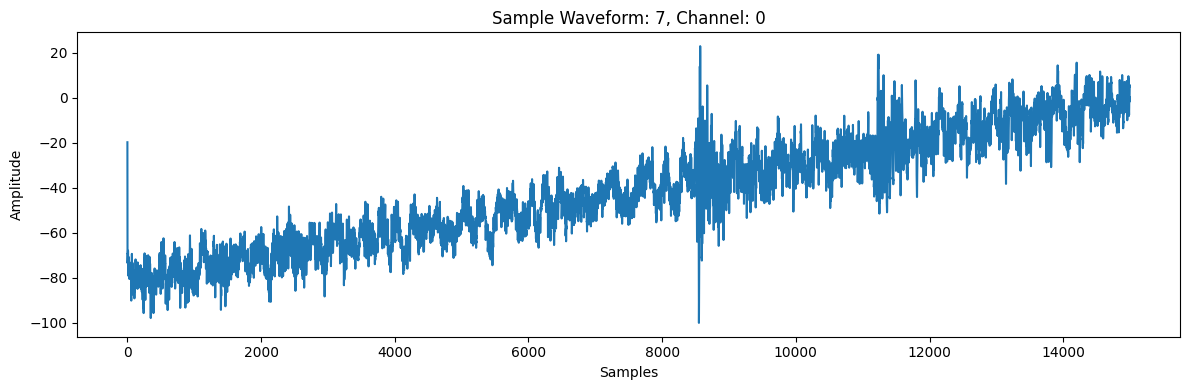

 - key 8: shape=(3, 1, 14998), min=-2580.34, max=2636.89
samplewaveform shape: (1, 14998)


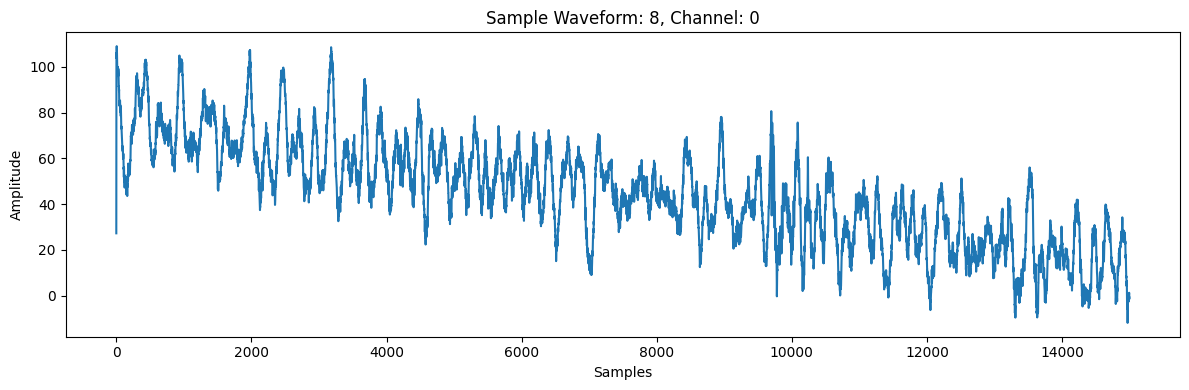

 - key 9: shape=(2, 1, 14998), min=-440.67, max=240.39
samplewaveform shape: (1, 14998)


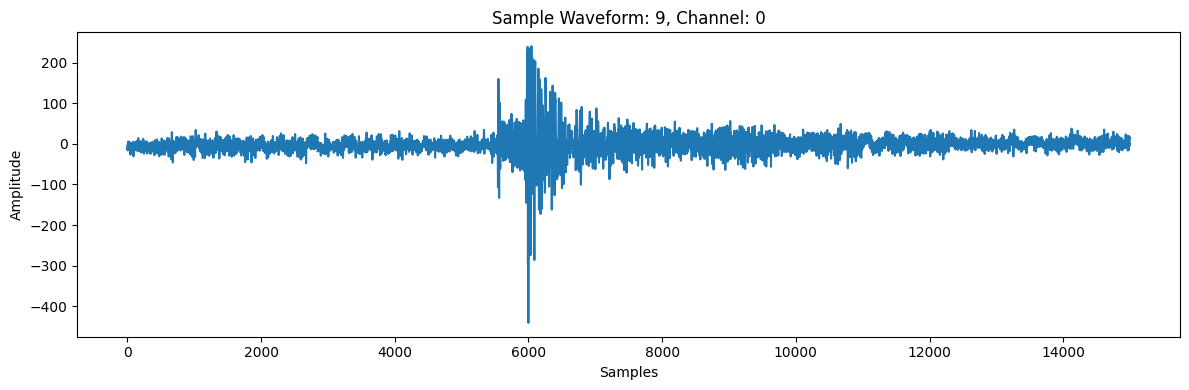

In [15]:
# Plot the waveforms from the HDF5 file

hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_close_to_midnight.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        for i, key in enumerate(list(waveforms_group.keys())[:]):
            waveform = waveforms_group[key][:]
            print(f" - key {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
        

            print('samplewaveform shape:', waveform[0].shape)

            for i in range(len(waveform[0])):
                plt.figure(figsize=(12, 4))
                y = waveform[0,i,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {key}, Channel: {i}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
            

    

In [16]:

# Print the metadata from the CSV file
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

event_id           source_origin_time  source_latitude_deg  \
0   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
1   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
2   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
3   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
4   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
5    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
6    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
7    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
8    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
9    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
10   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
11   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
12   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
13   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
14   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
15   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
16   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
17   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
18   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
19   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   

    source_longitude_deg  source_depth_km station_network_code  \
0             -122.16895          56111.0                   PB   
1             -122.16895          56111.0                   PB   
2             -122.16895          56111.0                   UW   
3             -122.16895          56111.0                   UW   
4             -122.16895          56111.0                   UW   
5             -121.77276           3820.0                   CN   
6             -121.77276           3820.0                   CN   
7             -121.77276           3820.0                   CN   
8             -121.77276           3820.0                   CN   
9             -121.77276           3820.0                   PB   
10            -121.77276           3820.0                   PB   
11            -121.77276           3820.0                   PB   
12            -121.77276           3820.0                   PB   
13            -121.77276           3820.0                   PB   
14            -121.77276           3820.0                   PB   
15            -121.77276           3820.0                   PB   
16            -121.77276           3820.0                   PB   
17            -121.77276           3820.0                   PB   
18            -121.77276           3820.0                   PB   
19            -121.77276           3820.0                   PB   

   station_channel_code station_code  station_location_code  \
0                    EH         B013                    NaN   
1                    EH         B943                    NaN   
2                    EH          BOW                    NaN   
3                    EH         PCMD                    NaN   
4                    EH          RVW                    NaN   
5                    EH          BIB                    NaN   
6                    EH         GOBB                    NaN   
7                    EH          VDB                    NaN   
8                    EH          WPB                    NaN   
9                    EH         B001                    NaN   
10                   EH         B003                    NaN   
11                   EH         B005                    NaN   
12                   EH         B007                    NaN   
13                   EH         B011                    NaN   
14                   EH         B013                    NaN   
15

### Test the script with NCEDC stations with traces across days

In [17]:
# Find BK station rows in assoc_df where pick_time is close to midnight (within 1 minute)
# Ensure 'datetime' column exists
if 'datetime' not in assoc_df.columns:
    assoc_df['datetime'] = pd.to_datetime(assoc_df['pick_time'], unit='s')

# Filter for BK stations
bk_mask = assoc_df['sta'].str.startswith('BK.')

# Find rows where the time is close to 23:59 (within 1 minute)
midnight_mask = assoc_df['datetime'].dt.time.between(pd.to_datetime('23:58:00').time(), pd.to_datetime('23:59:59').time())

bk_close_to_midnight = assoc_df[bk_mask & midnight_mask]
bk_close_to_midnight[['sta', 'pick_time', 'datetime']]

sta     pick_time                      datetime
324062  BK.JCC  1.338595e+09 2012-06-01 23:58:27.188393984
348863  BK.JCC  1.342656e+09 2012-07-18 23:59:42.138392832
371499  BK.JCC  1.346112e+09 2012-08-27 23:58:34.868392960
536319  BK.JCC  1.367453e+09 2013-05-01 23:59:19.488393984
536329  BK.JCC  1.367453e+09 2013-05-01 23:59:29.368393984
553360  BK.JCC  1.370045e+09 2013-05-31 23:59:13.338393088
553362  BK.JCC  1.370045e+09 2013-05-31 23:59:17.798393088
554103  BK.JCC  1.370217e+09 2013-06-02 23:58:09.088392960
733784  BK.JCC  1.404864e+09 2014-07-08 23:59:23.558393088
733795  BK.JCC  1.404864e+09 2014-07-08 23:59:28.278393088
817680  BK.JCC  1.413850e+09 2014-10-20 23:59:45.188393216
918992  BK.JCC  1.425427e+09 2015-03-03 23:58:15.698394112
970323  BK.JCC  1.431043e+09 2015-05-07 23:58:36.648393984
970340  BK.JCC  1.431043e+09 2015-05-07 23:58:49.298393856
981681  BK.JCC  1.432253e+09 2015-05-21 23:58:54.978393088

In [18]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_BK_HH_BH_close_to_midnight.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_BK_HH_BH_close_to_midnight.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_BK_EH_close_to_midnight.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_BK_EH_close_to_midnight.csv"

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Placeholder for client instances
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = client_iris  # replace with actual waveform client if different

# Replace with your actual DataFrame
# df = pd.read_csv(...) or load your 'close_to_midnight'
df = bk_close_to_midnight.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

waveform_buckets_HH_BH = {str(i): [] for i in range(11)}
waveform_buckets_EH = {str(i): [] for i in range(11)}
rows_HH_BH, rows_EH = [], []

def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        next_day = current.date + timedelta(days=1)  # Correct way to get the next day
        chunk_end = min(obspy.UTCDateTime(next_day), endtime)
        try:
            st_chunk = client.get_waveforms(
                network=network, station=station,
                location=location, channel=channel,
                starttime=current, endtime=chunk_end
            )
            stream += st_chunk
        except Exception as e:
            print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = chunk_end
    return stream


count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 40):
    print("-" * 50)
    # print("network:", network)
    # print("station:", station)
    # print("count:", count)
    count += 1

    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")

    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time
    trace_end = trace_start + window_length

    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)

    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    try:
        sta = client_iris.get_stations(network=network, station=station, location="*", channel="*",
                                       starttime=trace_start1, endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)
        continue

    try:
        if network in ['NC', 'BK']:
            _waveform = get_waveform_across_midnight(client_ncedc, network, station, "*", "*", trace_start1, trace_end1)
        else:
            _waveform = get_waveform_across_midnight(client_waveform, network, station, "*", "?H?", trace_start1, trace_end1)

        _waveform.merge(method=1, fill_value='interpolate')
        for tr in _waveform:
            tr.data = tr.data.astype(np.float64)
        _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0.0)
        _waveform.detrend()
        _waveform.resample(sampling_rate)

    except Exception as e:
        print("Error during waveform processing:", e)
        continue
    
    # print(_waveform)
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0] * 1000
    slat = sta[0][0].latitude
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    waveform = Stream()
    has_Z = bool(_waveform.select(channel='??Z'))
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue

    if has_HH:
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    for i, tr in enumerate(waveform):
        print(f"Trace {i}: id={tr.id}, channel={tr.stats.channel}, shape={tr.data.shape}")

    station_channel_code = waveform[0].stats.channel[:-1]
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
    num_trs, num_tps = data.shape

    p_sample = int((p_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not p_arrival.empty else None
    s_sample = int((s_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not s_arrival.empty else None

    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1089945/1694692375.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
No S arrival for event ev1338595094_500369 at station JCC
Trace start: 2012-06-01T23:57:24.500369Z, Trace end: 2012-06-01T23:59:54.500369Z
Trace 0: id=BK.JCC.00.HHE, channel=HHE, shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, channel=HHN, shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, channel=HHZ, shape=(15001,)
--------------------------------------------------
No S arrival for event ev1342655970_505147 at station JCC
Trace start: 2012-07-18T23:58:40.505147Z, Trace end: 2012-07-19T00:01:10.505147Z
Trace 0: id=BK.JCC.00.HHE, channel=HHE, shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, channel=HHN, shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, channel=HHZ, shape=(15001,)
--------------------------------------------------
No S arrival for event ev1346111897_526979 at station JCC
Trace start: 2012-08-27T23:57:27.526979Z, Trace end: 2012-08-27T23:59:57.526979Z
Trace 0: id=BK.JCC.00.HHE, channel=HHE, shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, channel=HHN, shape

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(2, 3, 14998), min=-5042.48, max=17517.04
 - 1: shape=(1, 3, 14998), min=-2023.97, max=15111.95
 - 10: shape=(1, 3, 14998), min=-1239.48, max=13309.96
 - 4: shape=(1, 3, 14998), min=-5484.10, max=13657.72
 - 5: shape=(1, 3, 14998), min=-11357.11, max=19644.16
 - 6: shape=(1, 3, 14998), min=-1946.64, max=13481.41
 - 7: shape=(2, 3, 14998), min=-8294.05, max=17321.39
 - 8: shape=(1, 3, 14998), min=-5119.41, max=15529.00
 - 9: shape=(1, 3, 14998), min=-2889.62, max=14361.95
 - key 0: shape=(2, 3, 14998), min=-5042.48, max=17517.04
samplewaveform shape: (3, 14998)


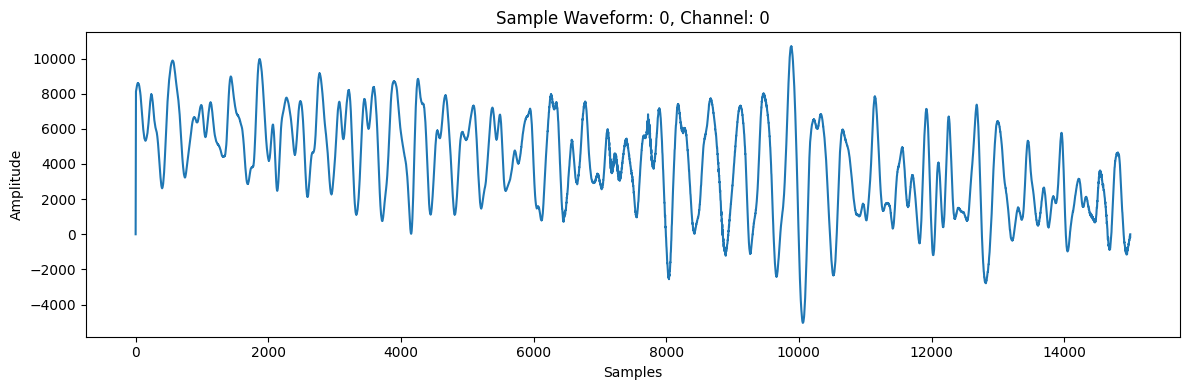

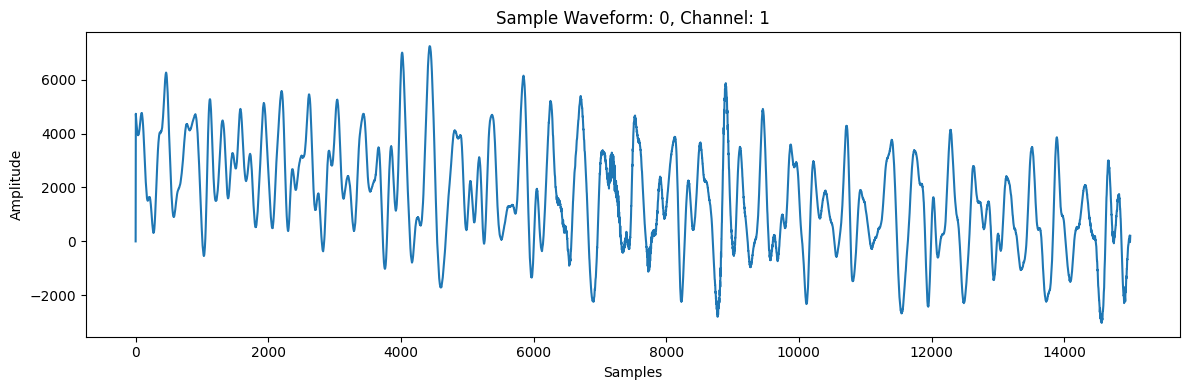

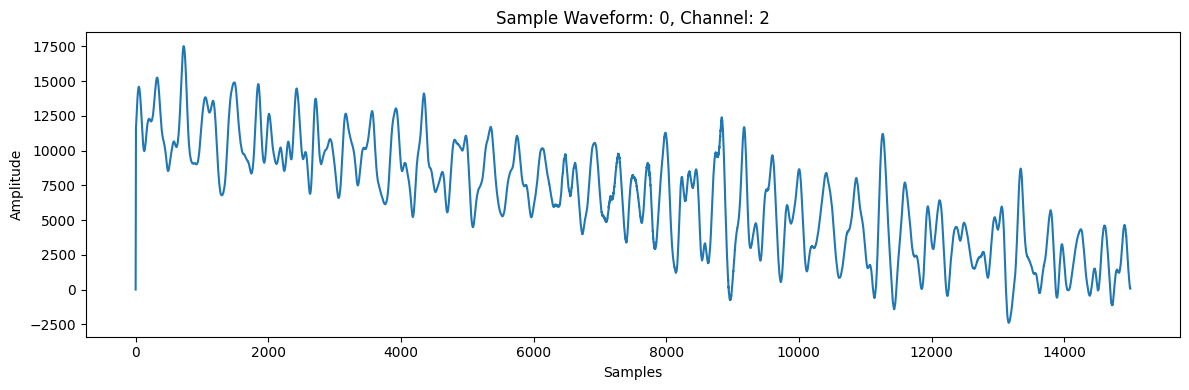

 - key 1: shape=(1, 3, 14998), min=-2023.97, max=15111.95
samplewaveform shape: (3, 14998)


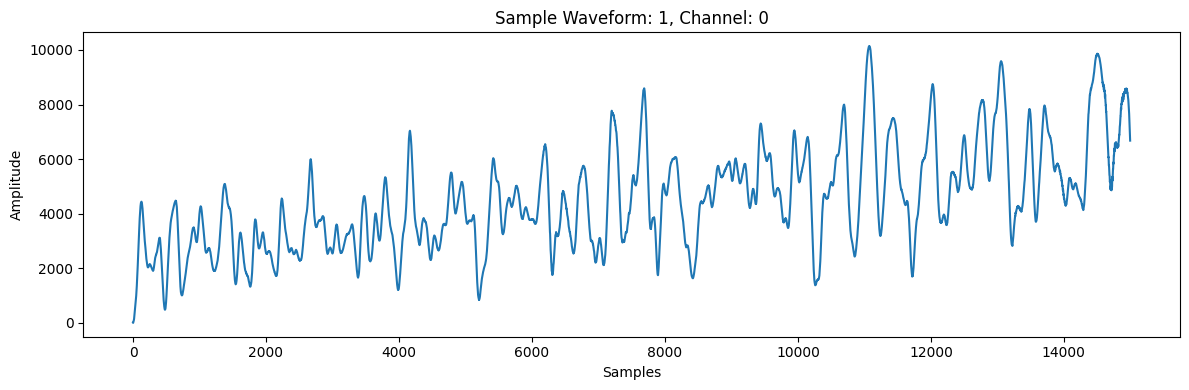

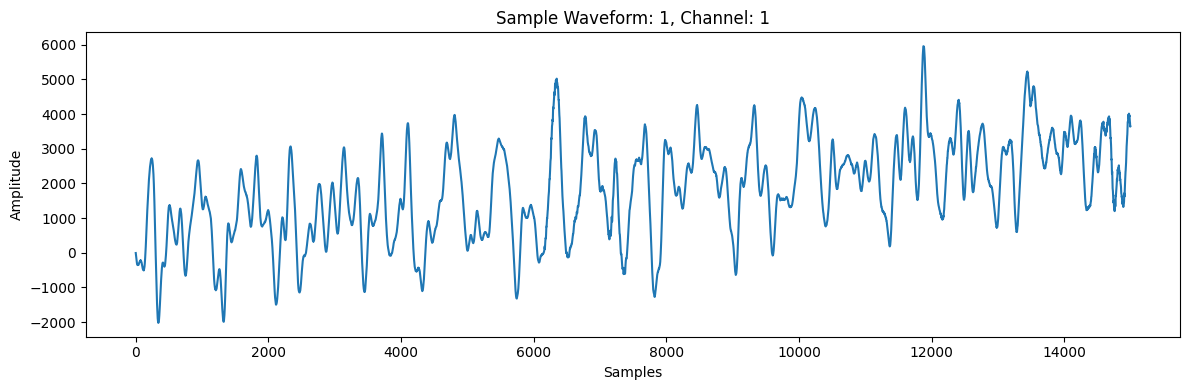

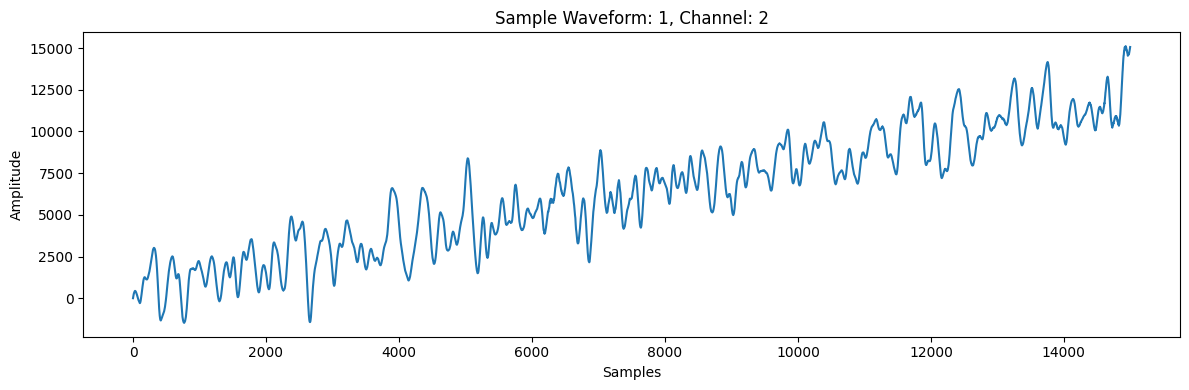

 - key 10: shape=(1, 3, 14998), min=-1239.48, max=13309.96
samplewaveform shape: (3, 14998)


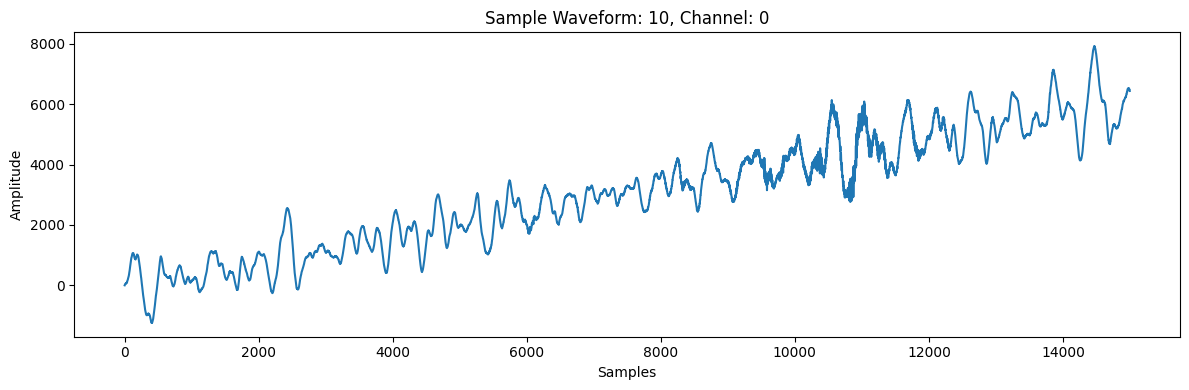

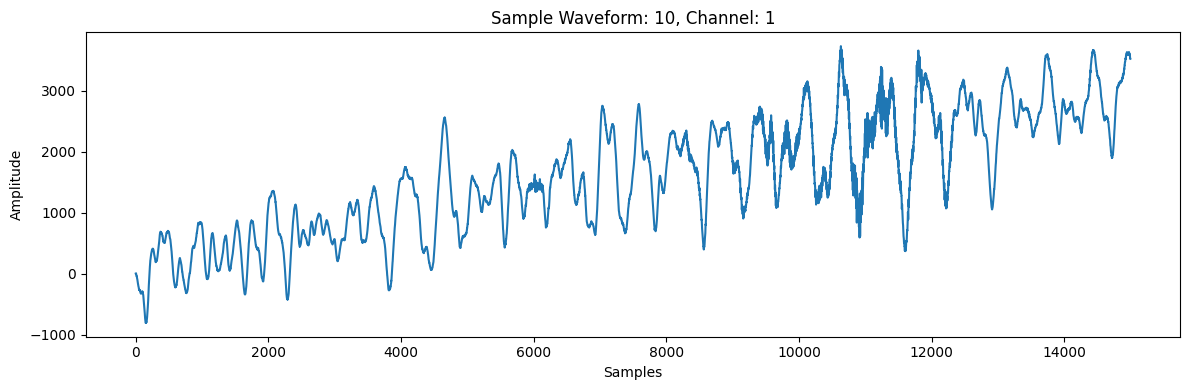

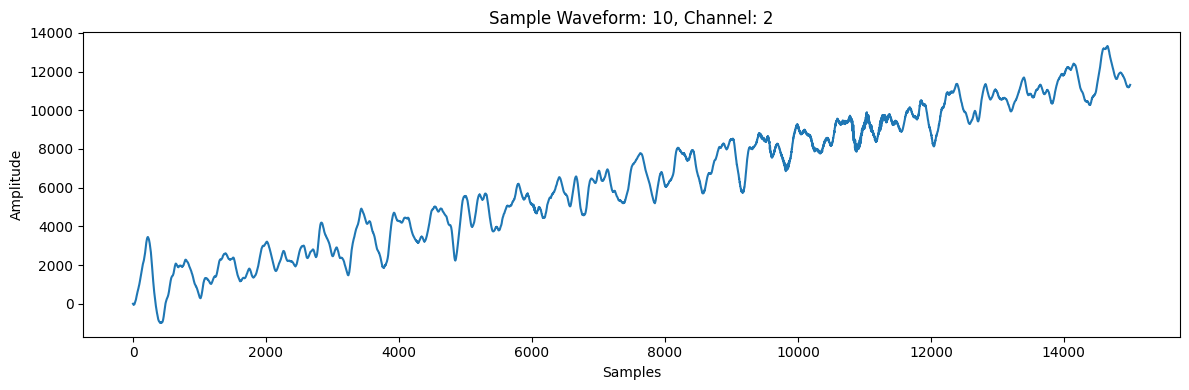

 - key 4: shape=(1, 3, 14998), min=-5484.10, max=13657.72
samplewaveform shape: (3, 14998)


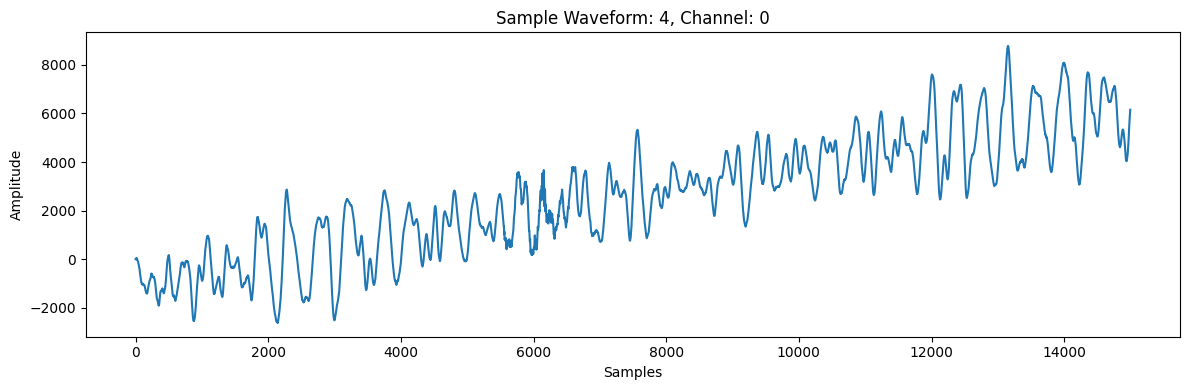

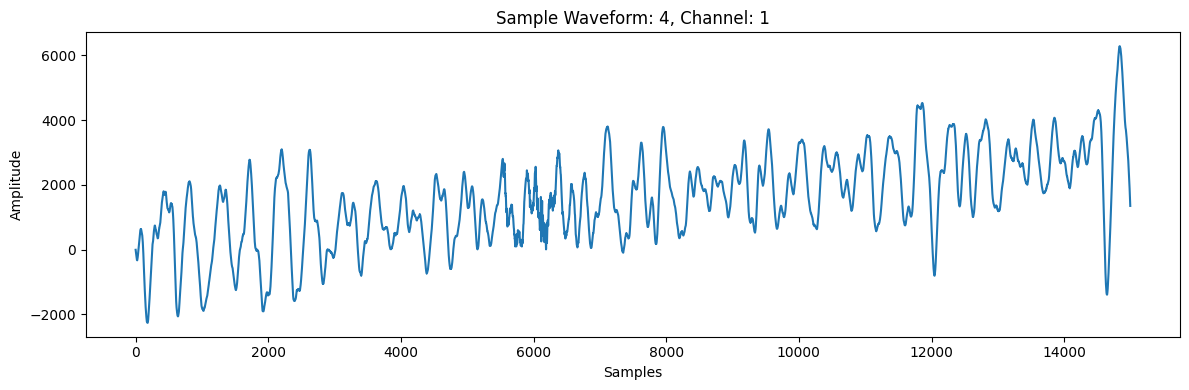

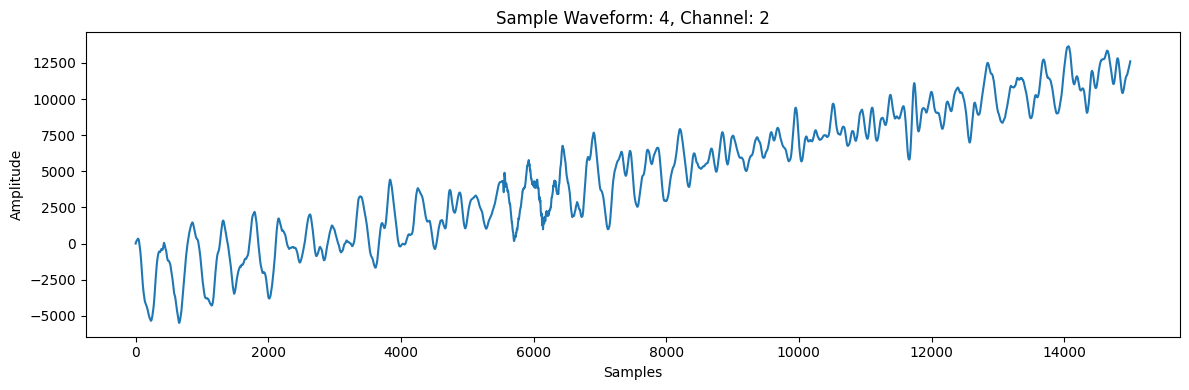

 - key 5: shape=(1, 3, 14998), min=-11357.11, max=19644.16
samplewaveform shape: (3, 14998)


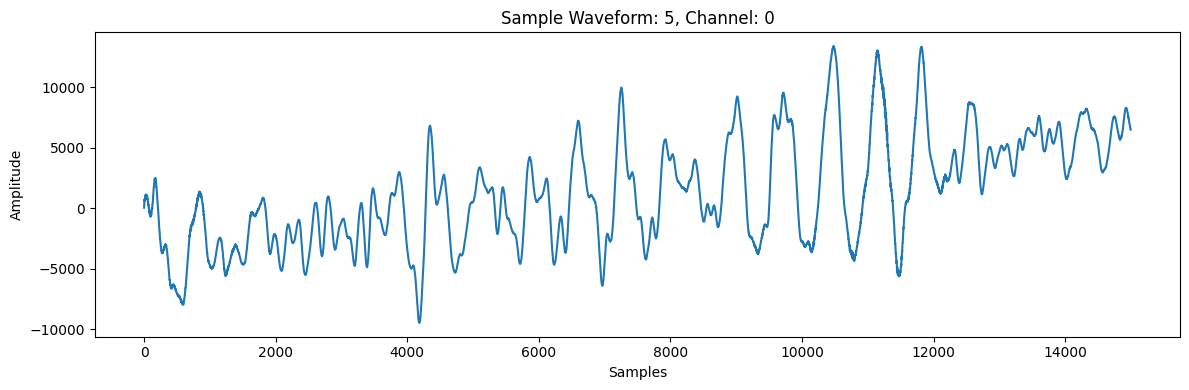

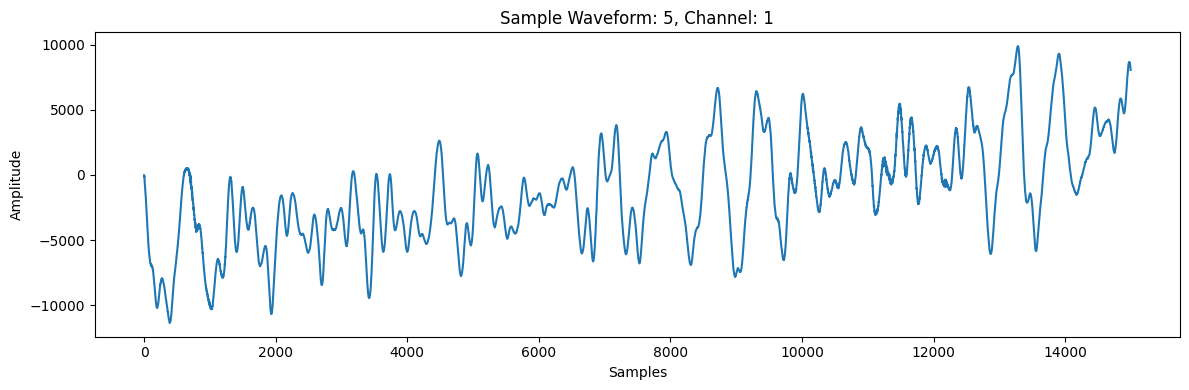

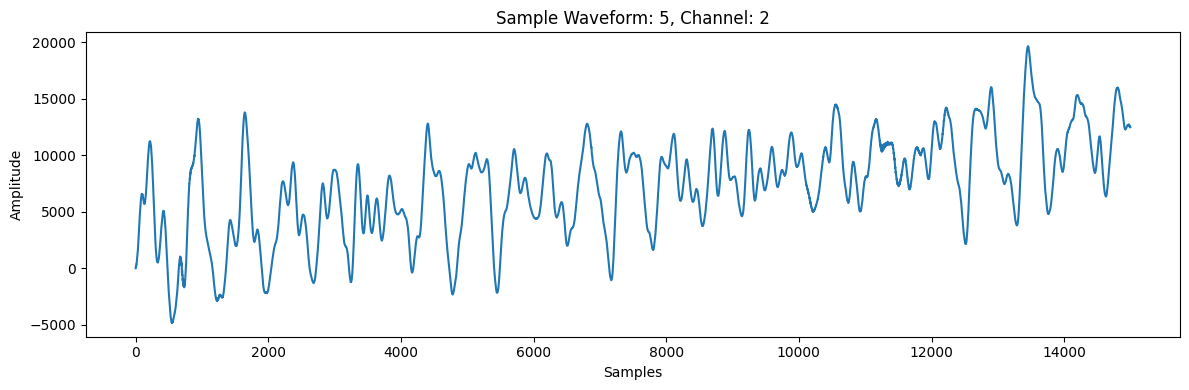

 - key 6: shape=(1, 3, 14998), min=-1946.64, max=13481.41
samplewaveform shape: (3, 14998)


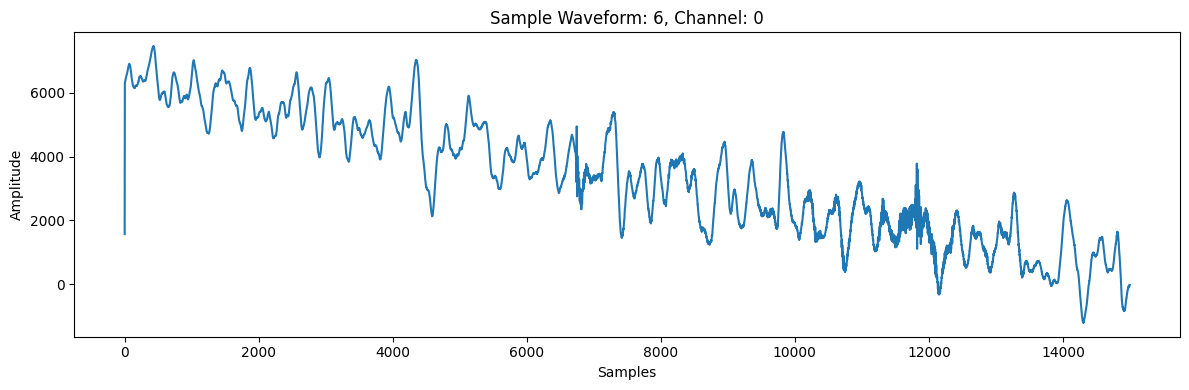

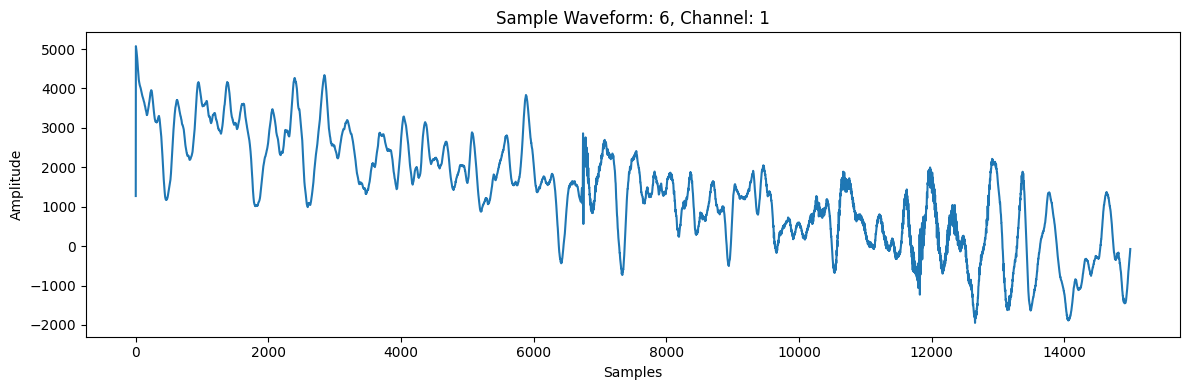

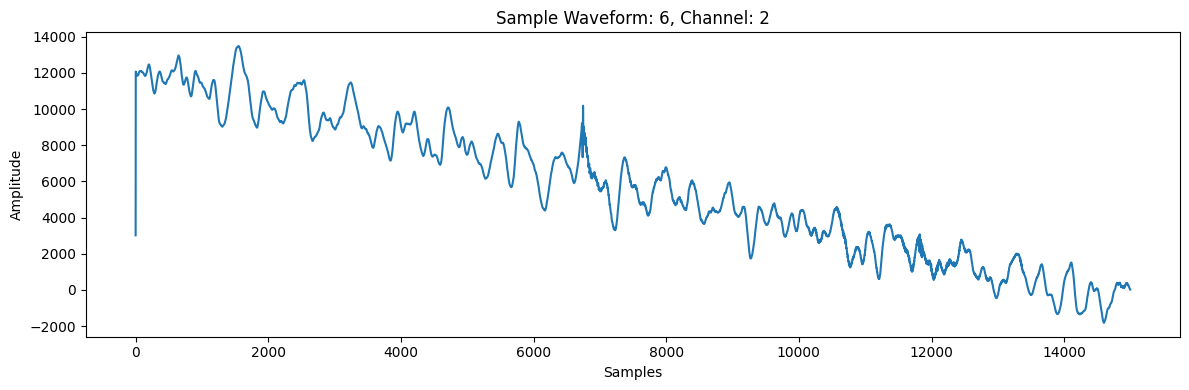

 - key 7: shape=(2, 3, 14998), min=-8294.05, max=17321.39
samplewaveform shape: (3, 14998)


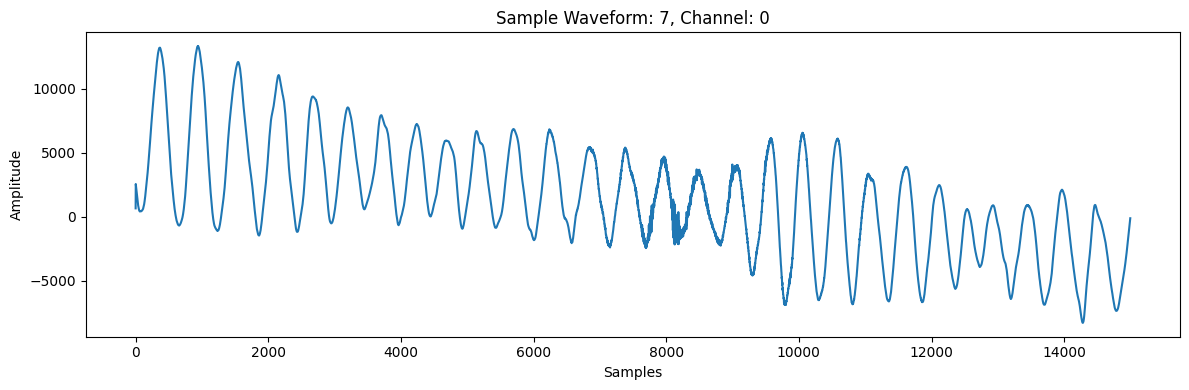

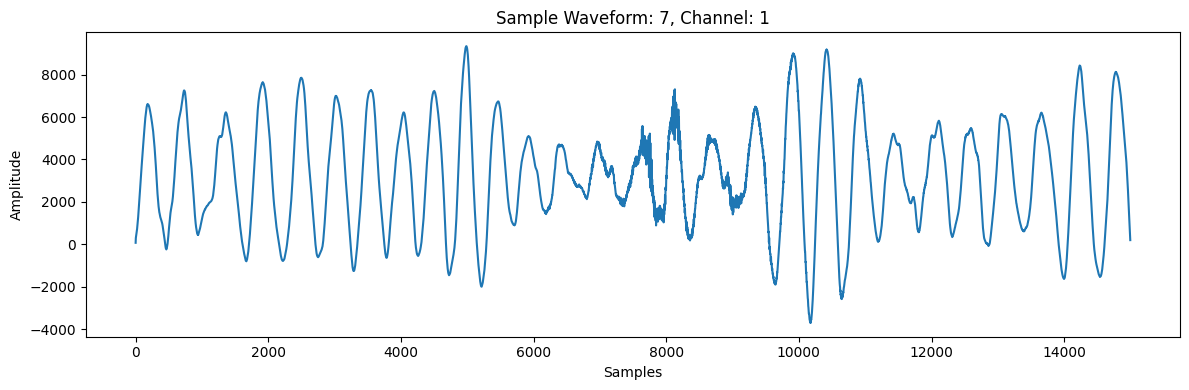

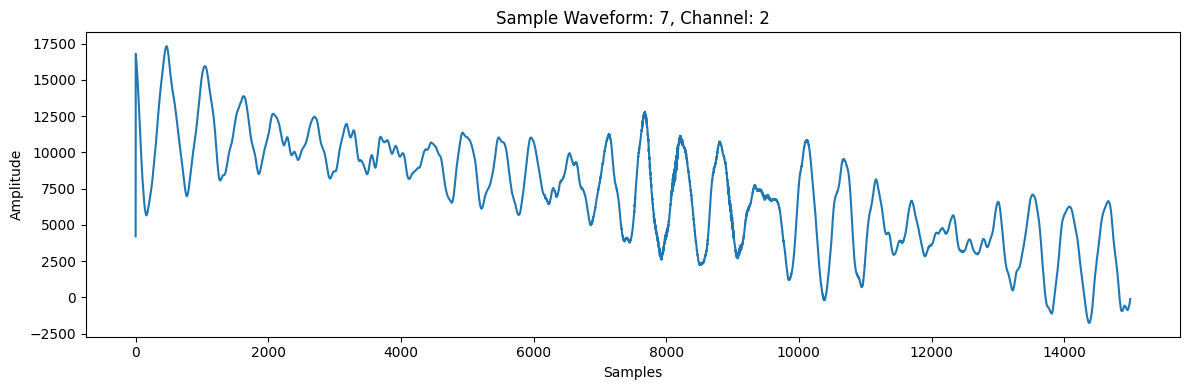

 - key 8: shape=(1, 3, 14998), min=-5119.41, max=15529.00
samplewaveform shape: (3, 14998)


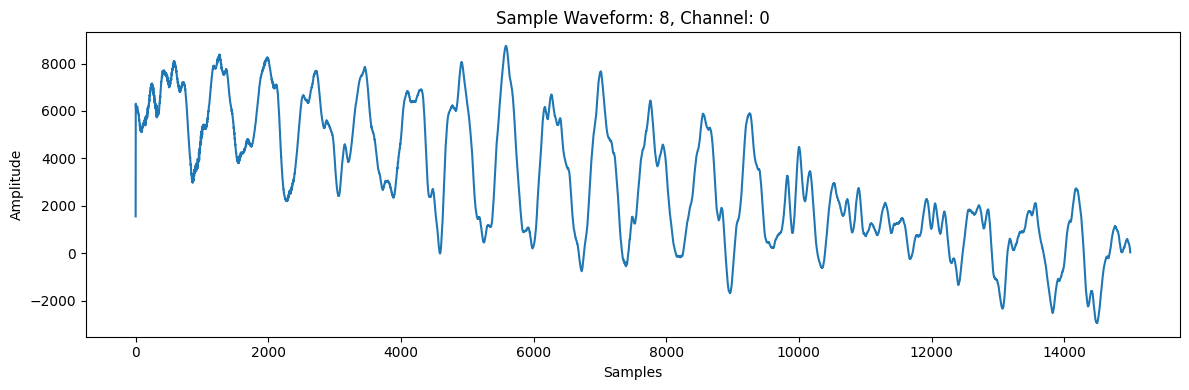

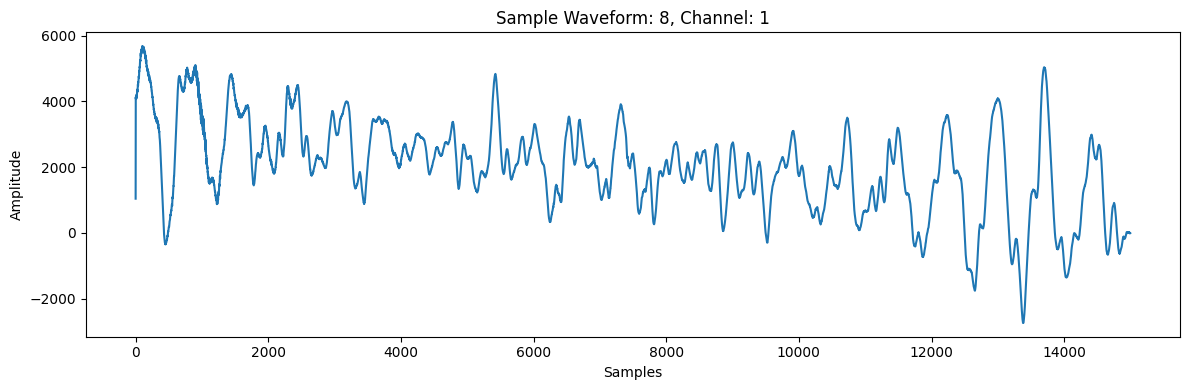

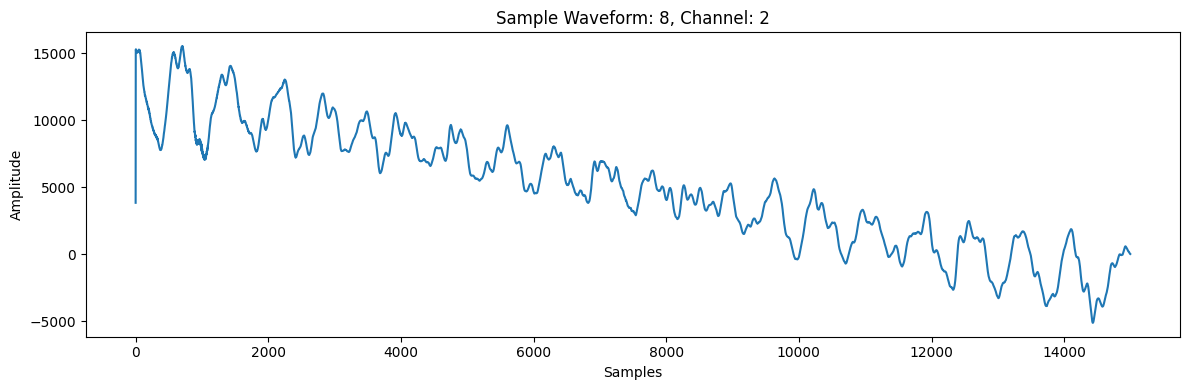

 - key 9: shape=(1, 3, 14998), min=-2889.62, max=14361.95
samplewaveform shape: (3, 14998)


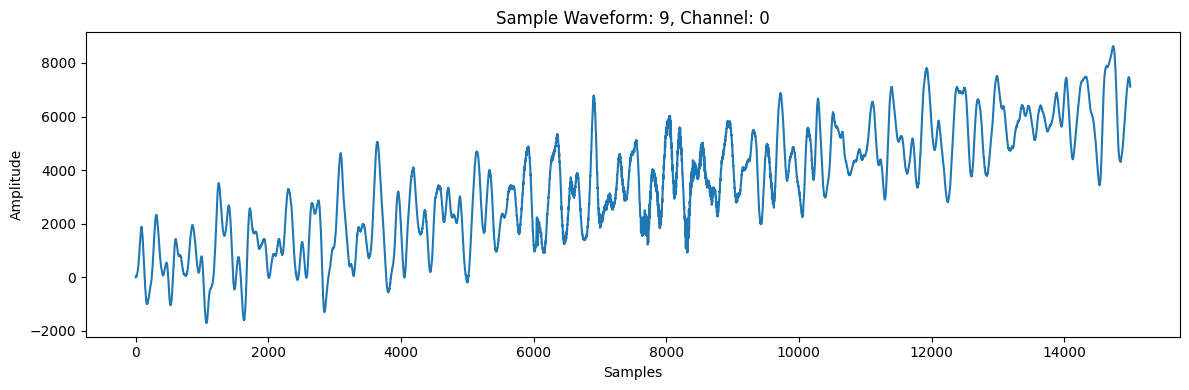

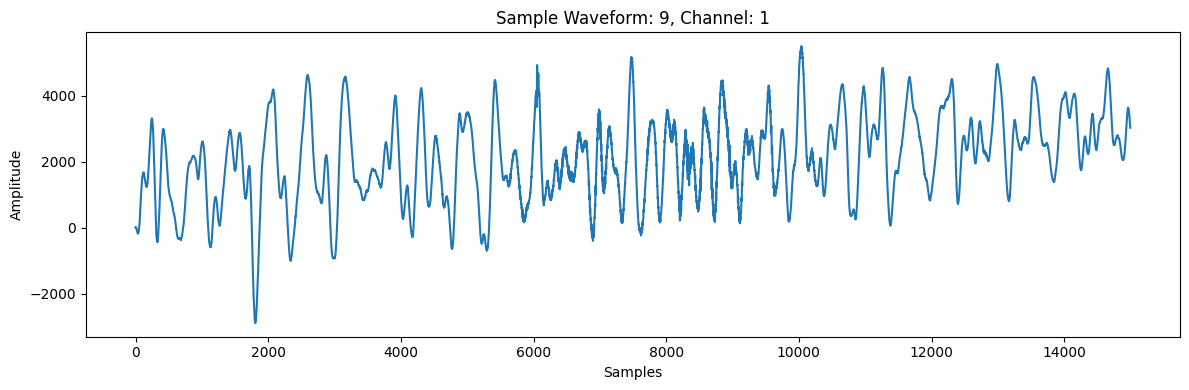

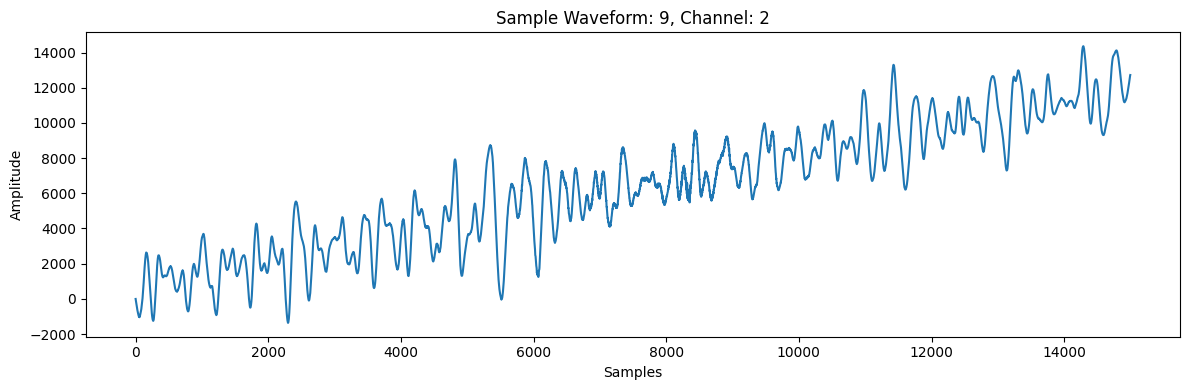

In [19]:
# Plot the waveforms from the HDF5 file

hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_BK_HH_BH_close_to_midnight.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        for i, key in enumerate(list(waveforms_group.keys())[:]):
            waveform = waveforms_group[key][:]
            print(f" - key {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
        

            print('samplewaveform shape:', waveform[0].shape)

            for i in range(len(waveform[0])):
                plt.figure(figsize=(12, 4))
                y = waveform[0,i,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {key}, Channel: {i}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
            

    

    

In [20]:
# Print the metadata from the CSV file

test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

event_id           source_origin_time  source_latitude_deg  \
0   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
1   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
2   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
3   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
4   ev1262304917_262282  2010-01-01T00:15:17.262282Z             47.22533   
5    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
6    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
7    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
8    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
9    ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
10   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
11   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
12   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
13   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
14   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
15   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
16   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
17   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
18   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   
19   ev1262305009_37536  2010-01-01T00:16:49.375360Z             48.19518   

    source_longitude_deg  source_depth_km station_network_code  \
0             -122.16895          56111.0                   PB   
1             -122.16895          56111.0                   PB   
2             -122.16895          56111.0                   UW   
3             -122.16895          56111.0                   UW   
4             -122.16895          56111.0                   UW   
5             -121.77276           3820.0                   CN   
6             -121.77276           3820.0                   CN   
7             -121.77276           3820.0                   CN   
8             -121.77276           3820.0                   CN   
9             -121.77276           3820.0                   PB   
10            -121.77276           3820.0                   PB   
11            -121.77276           3820.0                   PB   
12            -121.77276           3820.0                   PB   
13            -121.77276           3820.0                   PB   
14            -121.77276           3820.0                   PB   
15            -121.77276           3820.0                   PB   
16            -121.77276           3820.0                   PB   
17            -121.77276           3820.0                   PB   
18            -121.77276           3820.0                   PB   
19            -121.77276           3820.0                   PB   

   station_channel_code station_code  station_location_code  \
0                    EH         B013                    NaN   
1                    EH         B943                    NaN   
2                    EH          BOW                    NaN   
3                    EH         PCMD                    NaN   
4                    EH          RVW                    NaN   
5                    EH          BIB                    NaN   
6                    EH         GOBB                    NaN   
7                    EH          VDB                    NaN   
8                    EH          WPB                    NaN   
9                    EH         B001                    NaN   
10                   EH         B003                    NaN   
11                   EH         B005                    NaN   
12                   EH         B007                    NaN   
13                   EH         B011                    NaN   
14                   EH         B013                    NaN   
15

In [23]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH.csv"

# Extract network and station from sta column

df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data

    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)

    except Exception as e:
        print("Error during download or processing waveforms:", e)

    try:
        if network in ['NC', 'BK']:
            # Query waveforms
            _waveform = client_ncedc.get_waveforms(network=network, station=station, location="*", channel="*",
                                                starttime= trace_start1, endtime= trace_end1)
        else:
            # Shouldn't this have an explicit starttime + endtime inputs?
            _waveform = client_waveform.get_waveforms(network = network,
                                                    station = station,
                                                    location= "*",
                                                    channel = "?H?",
                                                    starttime = trace_start1, endtime = trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    # Detrend
    _waveform.detrend()
    # Resample the waveform traces to 100 Hz
    _waveform.resample(100)
    # Interpolate missing data
    _waveform.merge(method=1,fill_value='interpolate')
    # Fill the gaps at the start and end of the stream
    _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0)

    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1079918/3486799781.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


KeyboardInterrupt: 